# Importing Libs

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import os
os.environ["TF_METAL_ENABLED"] = "1"

if os.environ.get("TF_METAL_ENABLED") == "1":
    print('Metal GPU Activated')
else:
    print('CPU being used')

Metal GPU Activated


# Define Display & Pre-processing functions

In [157]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()
    
    
def preprocess(imgs):
        """
        Normalize and reshape the images
        """
        imgs = imgs.astype("float32") / 255.0
        imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
        imgs = np.expand_dims(imgs, -1)
        return imgs
        
def preprocess_forWGAN(img):
    """
    Noramzlizing image values and reshape the images
    """
    img = (tf.cast(img , "float32") - 127.5) / 127.5
    return img 


# Define and preprocess Data 🚧

In [158]:
train = pd.read_csv("archive/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

In [159]:
test = pd.read_csv("archive/fashion-mnist_test.csv")
test_x = test[list(test.columns)[1:]].values
test_y = test['label'].values

In [160]:
train_x = train_x.reshape(60000, 28 , 28)
x_train = np.array(train_x)

In [161]:
test_x = test_x.reshape(10000, 28 , 28)
text_x = np.array(test_x)

In [162]:

x_train = preprocess(train_x)
x_test = preprocess(test_x)

In [163]:
x_train.shape

(60000, 32, 32, 1)

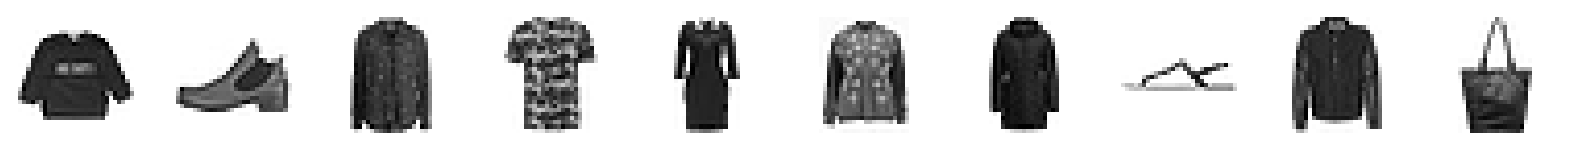

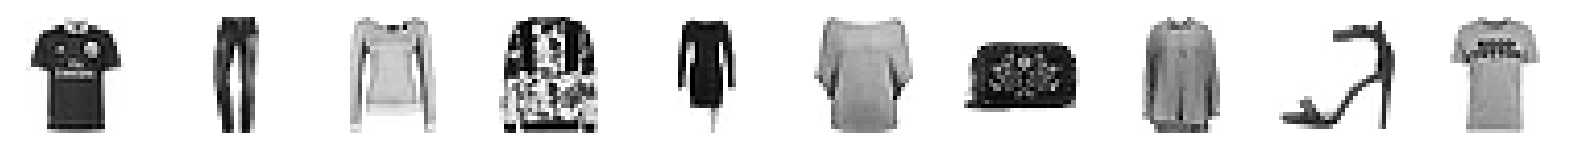

In [164]:
display(x_train)
display(x_test)

# 1. Variational Auto encoder model Building 🏗

## 1-1 Building Sampling Layer 🚧

In [165]:
#--> Sampling Layer

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        z_mean = tf.cast(z_mean, tf.float32)  # Cast z_mean to float32
        z_log_var = tf.cast(z_log_var, tf.float32)  # Cast z_log_var to float32
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), dtype=tf.float32)
        z_log_var_exp = tf.exp(0.5 * z_log_var)
        return z_mean + epsilon * z_log_var_exp


## 1-2 Building the encoder 🚧


In [166]:
#--> Encoder

encoder_input = layers.Input(shape = (32 , 32 , 1) , name = 'encoder_input')
x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)  # Additional layer
x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)  # Additional layer

shape_before_Flatting = K.int_shape(x)[1:] #--> We will need this in the decoder side
x = layers.Flatten()(x)
z_mean = layers.Dense(2 , name = "z_mean")(x)
z_log_var = layers.Dense(2 , name = "z_log_var")(x)
z = Sampling()([z_mean  , z_log_var])

encoder = models.Model(encoder_input , [z_mean , z_log_var , z] , name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_47 (Conv2D)          (None, 16, 16, 64)           640       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 8, 8, 128)            73856     ['conv2d_47[0][0]']           
                                                                                                  
 conv2d_49 (Conv2D)          (None, 4, 4, 256)            295168    ['conv2d_48[0][0]']           
                                                                                            

## 1-3 Building the Decoder🚧

In [167]:
#----> Building the decoder
decoder_input = layers.Input(shape = (2 , ) , name = "Decoder_inputs")
x = layers.Dense(np.prod(shape_before_Flatting))(decoder_input)
x = layers.Reshape(shape_before_Flatting)(x)
x = layers.Conv2DTranspose(512, 3, activation='relu', padding='same')(x)  # Additional layer
x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)  # Updated filter size
x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
decoder_outputs = layers.Conv2D(1 , 3 , strides = 1 , padding = 'same' , activation = 'sigmoid' , name = 'decoder_outputs')(x)
decoder = models.Model(decoder_input , decoder_outputs)
decoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_inputs (InputLayer  [(None, 2)]               0         
 )                                                               
                                                                 
 dense_12 (Dense)            (None, 8192)              24576     
                                                                 
 reshape_8 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_27 (Conv2  (None, 4, 4, 512)         2359808   
 DTranspose)                                                     
                                                                 
 conv2d_transpose_28 (Conv2  (None, 8, 8, 256)         1179904   
 DTranspose)                                                     
                                                          

## 1-4 Buildint the variational autoencoder class 🚧

In [168]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [169]:
#Define the autoencoder
vae = VAE(encoder, decoder)

## Compile and fit the VAE🚧

In [170]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=vae_loss)

In [171]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/model-{epoch:02d}.keras",    
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

In [172]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 160
BETA = 500

In [174]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

history = vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/120
600/600 [==============================] - ETA: 0s - total_loss: 132.9502 - reconstruction_loss: 127.9808 - kl_loss: 4.9674WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 34s 55ms/step - total_loss: 132.9502 - reconstruction_loss: 127.9808 - kl_loss: 4.9674
Epoch 2/120
600/600 [==============================] - ETA: 0s - total_loss: 131.5424 - reconstruction_loss: 126.4496 - kl_loss: 5.0916WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 34s 56ms/step - total_loss: 131.5424 - reconstruction_loss: 126.4496 - kl_loss: 5.0916
Epoch 3/120
600/600 [==============================] - ETA: 0s - total_loss: 130.7299 - reconstruction_loss: 125.5379 - kl_loss: 5.1928WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 34s 57ms/step - total_loss: 130.7299 - reconstruction_loss: 125.5379 - kl_loss: 5.1928
Epoch 4/120
600/600 [==============================] - ETA: 0s - total_loss: 130.1589 - reconstruction_loss: 124.8934 - kl_loss: 5.2646WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 33s 55ms/step - total_loss: 130.1589 - reconstruction_loss: 124.8934 - kl_loss: 5.2646
Epoch 5/120
600/600 [==============================] - ETA: 0s - total_loss: 129.6664 - reconstruction_loss: 124.3369 - kl_loss: 5.3305WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 54ms/step - total_loss: 129.6664 - reconstruction_loss: 124.3369 - kl_loss: 5.3305
Epoch 6/120
600/600 [==============================] - ETA: 0s - total_loss: 129.3291 - reconstruction_loss: 123.9503 - kl_loss: 5.3773WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 54ms/step - total_loss: 129.3291 - reconstruction_loss: 123.9503 - kl_loss: 5.3773
Epoch 7/120
600/600 [==============================] - ETA: 0s - total_loss: 129.0478 - reconstruction_loss: 123.6264 - kl_loss: 5.4205WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 33s 55ms/step - total_loss: 129.0478 - reconstruction_loss: 123.6264 - kl_loss: 5.4205
Epoch 8/120
600/600 [==============================] - ETA: 0s - total_loss: 128.8229 - reconstruction_loss: 123.3553 - kl_loss: 5.4693WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 54ms/step - total_loss: 128.8229 - reconstruction_loss: 123.3553 - kl_loss: 5.4693
Epoch 9/120
600/600 [==============================] - ETA: 0s - total_loss: 128.5900 - reconstruction_loss: 123.0978 - kl_loss: 5.4919WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 33s 54ms/step - total_loss: 128.5900 - reconstruction_loss: 123.0978 - kl_loss: 5.4919
Epoch 10/120
600/600 [==============================] - ETA: 0s - total_loss: 128.3491 - reconstruction_loss: 122.8217 - kl_loss: 5.5267WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 54ms/step - total_loss: 128.3491 - reconstruction_loss: 122.8217 - kl_loss: 5.5267
Epoch 11/120
600/600 [==============================] - ETA: 0s - total_loss: 128.2460 - reconstruction_loss: 122.6953 - kl_loss: 5.5521WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 54ms/step - total_loss: 128.2460 - reconstruction_loss: 122.6953 - kl_loss: 5.5521
Epoch 12/120
600/600 [==============================] - ETA: 0s - total_loss: 128.0472 - reconstruction_loss: 122.4484 - kl_loss: 5.5985WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 33s 54ms/step - total_loss: 128.0472 - reconstruction_loss: 122.4484 - kl_loss: 5.5985
Epoch 13/120
600/600 [==============================] - ETA: 0s - total_loss: 127.9368 - reconstruction_loss: 122.3181 - kl_loss: 5.6178WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 54ms/step - total_loss: 127.9368 - reconstruction_loss: 122.3181 - kl_loss: 5.6178
Epoch 14/120
600/600 [==============================] - ETA: 0s - total_loss: 127.7910 - reconstruction_loss: 122.1469 - kl_loss: 5.6440WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 33s 55ms/step - total_loss: 127.7910 - reconstruction_loss: 122.1469 - kl_loss: 5.6440
Epoch 15/120
600/600 [==============================] - ETA: 0s - total_loss: 127.5819 - reconstruction_loss: 121.9146 - kl_loss: 5.6673WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 54ms/step - total_loss: 127.5819 - reconstruction_loss: 121.9146 - kl_loss: 5.6673
Epoch 16/120
600/600 [==============================] - ETA: 0s - total_loss: 127.5456 - reconstruction_loss: 121.8637 - kl_loss: 5.6800WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 33s 54ms/step - total_loss: 127.5456 - reconstruction_loss: 121.8637 - kl_loss: 5.6800
Epoch 17/120
600/600 [==============================] - ETA: 0s - total_loss: 127.3682 - reconstruction_loss: 121.6696 - kl_loss: 5.6986WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 54ms/step - total_loss: 127.3682 - reconstruction_loss: 121.6696 - kl_loss: 5.6986
Epoch 18/120
600/600 [==============================] - ETA: 0s - total_loss: 127.3796 - reconstruction_loss: 121.6611 - kl_loss: 5.7173WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 127.3796 - reconstruction_loss: 121.6611 - kl_loss: 5.7173
Epoch 19/120
600/600 [==============================] - ETA: 0s - total_loss: 127.1493 - reconstruction_loss: 121.4105 - kl_loss: 5.7404WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 127.1493 - reconstruction_loss: 121.4105 - kl_loss: 5.7404
Epoch 20/120
600/600 [==============================] - ETA: 0s - total_loss: 127.2129 - reconstruction_loss: 121.4557 - kl_loss: 5.7568WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 127.2129 - reconstruction_loss: 121.4557 - kl_loss: 5.7568
Epoch 21/120
600/600 [==============================] - ETA: 0s - total_loss: 127.1633 - reconstruction_loss: 121.3927 - kl_loss: 5.7686WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 127.1633 - reconstruction_loss: 121.3927 - kl_loss: 5.7686
Epoch 22/120
600/600 [==============================] - ETA: 0s - total_loss: 127.0516 - reconstruction_loss: 121.2649 - kl_loss: 5.7859WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 127.0516 - reconstruction_loss: 121.2649 - kl_loss: 5.7859
Epoch 23/120
600/600 [==============================] - ETA: 0s - total_loss: 126.8625 - reconstruction_loss: 121.0587 - kl_loss: 5.8046WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.8625 - reconstruction_loss: 121.0587 - kl_loss: 5.8046
Epoch 24/120
600/600 [==============================] - ETA: 0s - total_loss: 126.9324 - reconstruction_loss: 121.1275 - kl_loss: 5.8049WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.9324 - reconstruction_loss: 121.1275 - kl_loss: 5.8049
Epoch 25/120
600/600 [==============================] - ETA: 0s - total_loss: 126.7682 - reconstruction_loss: 120.9470 - kl_loss: 5.8214WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.7682 - reconstruction_loss: 120.9470 - kl_loss: 5.8214
Epoch 26/120
600/600 [==============================] - ETA: 0s - total_loss: 126.6945 - reconstruction_loss: 120.8584 - kl_loss: 5.8344WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.6945 - reconstruction_loss: 120.8584 - kl_loss: 5.8344
Epoch 27/120
600/600 [==============================] - ETA: 0s - total_loss: 126.6167 - reconstruction_loss: 120.7734 - kl_loss: 5.8448WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.6167 - reconstruction_loss: 120.7734 - kl_loss: 5.8448
Epoch 28/120
600/600 [==============================] - ETA: 0s - total_loss: 126.5752 - reconstruction_loss: 120.7197 - kl_loss: 5.8545WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.5752 - reconstruction_loss: 120.7197 - kl_loss: 5.8545
Epoch 29/120
600/600 [==============================] - ETA: 0s - total_loss: 126.5802 - reconstruction_loss: 120.7223 - kl_loss: 5.8571WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.5802 - reconstruction_loss: 120.7223 - kl_loss: 5.8571
Epoch 30/120
600/600 [==============================] - ETA: 0s - total_loss: 126.5553 - reconstruction_loss: 120.6894 - kl_loss: 5.8661WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.5553 - reconstruction_loss: 120.6894 - kl_loss: 5.8661
Epoch 31/120
600/600 [==============================] - ETA: 0s - total_loss: 126.4005 - reconstruction_loss: 120.5117 - kl_loss: 5.8891WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.4005 - reconstruction_loss: 120.5117 - kl_loss: 5.8891
Epoch 32/120
600/600 [==============================] - ETA: 0s - total_loss: 126.4289 - reconstruction_loss: 120.5332 - kl_loss: 5.8979WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.4289 - reconstruction_loss: 120.5332 - kl_loss: 5.8979
Epoch 33/120
600/600 [==============================] - ETA: 0s - total_loss: 126.3470 - reconstruction_loss: 120.4289 - kl_loss: 5.9201WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 126.3470 - reconstruction_loss: 120.4289 - kl_loss: 5.9201
Epoch 34/120
600/600 [==============================] - ETA: 0s - total_loss: 126.2384 - reconstruction_loss: 120.3178 - kl_loss: 5.9203WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 126.2384 - reconstruction_loss: 120.3178 - kl_loss: 5.9203
Epoch 35/120
600/600 [==============================] - ETA: 0s - total_loss: 126.1916 - reconstruction_loss: 120.2581 - kl_loss: 5.9329WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.1916 - reconstruction_loss: 120.2581 - kl_loss: 5.9329
Epoch 36/120
600/600 [==============================] - ETA: 0s - total_loss: 126.3223 - reconstruction_loss: 120.3988 - kl_loss: 5.9223WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.3223 - reconstruction_loss: 120.3988 - kl_loss: 5.9223
Epoch 37/120
600/600 [==============================] - ETA: 0s - total_loss: 126.1694 - reconstruction_loss: 120.2335 - kl_loss: 5.9345WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.1694 - reconstruction_loss: 120.2335 - kl_loss: 5.9345
Epoch 38/120
600/600 [==============================] - ETA: 0s - total_loss: 126.2403 - reconstruction_loss: 120.2940 - kl_loss: 5.9461WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.2403 - reconstruction_loss: 120.2940 - kl_loss: 5.9461
Epoch 39/120
600/600 [==============================] - ETA: 0s - total_loss: 126.1041 - reconstruction_loss: 120.1368 - kl_loss: 5.9681WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.1041 - reconstruction_loss: 120.1368 - kl_loss: 5.9681
Epoch 40/120
600/600 [==============================] - ETA: 0s - total_loss: 126.0404 - reconstruction_loss: 120.0730 - kl_loss: 5.9687WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.0404 - reconstruction_loss: 120.0730 - kl_loss: 5.9687
Epoch 41/120
600/600 [==============================] - ETA: 0s - total_loss: 126.0632 - reconstruction_loss: 120.0859 - kl_loss: 5.9780WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.0632 - reconstruction_loss: 120.0859 - kl_loss: 5.9780
Epoch 42/120
600/600 [==============================] - ETA: 0s - total_loss: 126.0224 - reconstruction_loss: 120.0424 - kl_loss: 5.9814WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 126.0224 - reconstruction_loss: 120.0424 - kl_loss: 5.9814
Epoch 43/120
600/600 [==============================] - ETA: 0s - total_loss: 125.8982 - reconstruction_loss: 119.9044 - kl_loss: 5.9930WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 125.8982 - reconstruction_loss: 119.9044 - kl_loss: 5.9930
Epoch 44/120
600/600 [==============================] - ETA: 0s - total_loss: 125.8460 - reconstruction_loss: 119.8377 - kl_loss: 6.0101WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 125.8460 - reconstruction_loss: 119.8377 - kl_loss: 6.0101
Epoch 45/120
600/600 [==============================] - ETA: 0s - total_loss: 125.9125 - reconstruction_loss: 119.9240 - kl_loss: 5.9888WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.9125 - reconstruction_loss: 119.9240 - kl_loss: 5.9888
Epoch 46/120
600/600 [==============================] - ETA: 0s - total_loss: 126.1031 - reconstruction_loss: 120.1144 - kl_loss: 5.9888WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 126.1031 - reconstruction_loss: 120.1144 - kl_loss: 5.9888
Epoch 47/120
600/600 [==============================] - ETA: 0s - total_loss: 125.8208 - reconstruction_loss: 119.8117 - kl_loss: 6.0126WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.8208 - reconstruction_loss: 119.8117 - kl_loss: 6.0126
Epoch 48/120
600/600 [==============================] - ETA: 0s - total_loss: 125.8925 - reconstruction_loss: 119.8801 - kl_loss: 6.0132WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.8925 - reconstruction_loss: 119.8801 - kl_loss: 6.0132
Epoch 49/120
600/600 [==============================] - ETA: 0s - total_loss: 125.6940 - reconstruction_loss: 119.6667 - kl_loss: 6.0280WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 125.6940 - reconstruction_loss: 119.6667 - kl_loss: 6.0280
Epoch 50/120
600/600 [==============================] - ETA: 0s - total_loss: 125.6950 - reconstruction_loss: 119.6558 - kl_loss: 6.0401WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.6950 - reconstruction_loss: 119.6558 - kl_loss: 6.0401
Epoch 51/120
600/600 [==============================] - ETA: 0s - total_loss: 125.6694 - reconstruction_loss: 119.6176 - kl_loss: 6.0504WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.6694 - reconstruction_loss: 119.6176 - kl_loss: 6.0504
Epoch 52/120
600/600 [==============================] - ETA: 0s - total_loss: 125.6347 - reconstruction_loss: 119.5865 - kl_loss: 6.0473WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.6347 - reconstruction_loss: 119.5865 - kl_loss: 6.0473
Epoch 53/120
600/600 [==============================] - ETA: 0s - total_loss: 125.7436 - reconstruction_loss: 119.7038 - kl_loss: 6.0399WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.7436 - reconstruction_loss: 119.7038 - kl_loss: 6.0399
Epoch 54/120
600/600 [==============================] - ETA: 0s - total_loss: 125.5189 - reconstruction_loss: 119.4623 - kl_loss: 6.0552WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.5189 - reconstruction_loss: 119.4623 - kl_loss: 6.0552
Epoch 55/120
600/600 [==============================] - ETA: 0s - total_loss: 125.5385 - reconstruction_loss: 119.4703 - kl_loss: 6.0681WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.5385 - reconstruction_loss: 119.4703 - kl_loss: 6.0681
Epoch 56/120
600/600 [==============================] - ETA: 0s - total_loss: 125.7134 - reconstruction_loss: 119.6687 - kl_loss: 6.0462WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.7134 - reconstruction_loss: 119.6687 - kl_loss: 6.0462
Epoch 57/120
600/600 [==============================] - ETA: 0s - total_loss: 125.5316 - reconstruction_loss: 119.4543 - kl_loss: 6.0781WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.5316 - reconstruction_loss: 119.4543 - kl_loss: 6.0781
Epoch 58/120
600/600 [==============================] - ETA: 0s - total_loss: 125.5543 - reconstruction_loss: 119.4720 - kl_loss: 6.0820WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.5543 - reconstruction_loss: 119.4720 - kl_loss: 6.0820
Epoch 59/120
600/600 [==============================] - ETA: 0s - total_loss: 125.6240 - reconstruction_loss: 119.5439 - kl_loss: 6.0794WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.6240 - reconstruction_loss: 119.5439 - kl_loss: 6.0794
Epoch 60/120
600/600 [==============================] - ETA: 0s - total_loss: 125.4665 - reconstruction_loss: 119.3651 - kl_loss: 6.1023WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.4665 - reconstruction_loss: 119.3651 - kl_loss: 6.1023
Epoch 61/120
600/600 [==============================] - ETA: 0s - total_loss: 125.4573 - reconstruction_loss: 119.3535 - kl_loss: 6.1043WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.4573 - reconstruction_loss: 119.3535 - kl_loss: 6.1043
Epoch 62/120
600/600 [==============================] - ETA: 0s - total_loss: 125.4734 - reconstruction_loss: 119.3715 - kl_loss: 6.1012WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.4734 - reconstruction_loss: 119.3715 - kl_loss: 6.1012
Epoch 63/120
600/600 [==============================] - ETA: 0s - total_loss: 125.3452 - reconstruction_loss: 119.2353 - kl_loss: 6.1089WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.3452 - reconstruction_loss: 119.2353 - kl_loss: 6.1089
Epoch 64/120
600/600 [==============================] - ETA: 0s - total_loss: 125.3868 - reconstruction_loss: 119.2734 - kl_loss: 6.1119WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.3868 - reconstruction_loss: 119.2734 - kl_loss: 6.1119
Epoch 65/120
600/600 [==============================] - ETA: 0s - total_loss: 125.3805 - reconstruction_loss: 119.2608 - kl_loss: 6.1193WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.3805 - reconstruction_loss: 119.2608 - kl_loss: 6.1193
Epoch 66/120
600/600 [==============================] - ETA: 0s - total_loss: 125.3218 - reconstruction_loss: 119.1969 - kl_loss: 6.1259WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.3218 - reconstruction_loss: 119.1969 - kl_loss: 6.1259
Epoch 67/120
600/600 [==============================] - ETA: 0s - total_loss: 125.2305 - reconstruction_loss: 119.0936 - kl_loss: 6.1368WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.2305 - reconstruction_loss: 119.0936 - kl_loss: 6.1368
Epoch 68/120
600/600 [==============================] - ETA: 0s - total_loss: 125.5422 - reconstruction_loss: 119.4228 - kl_loss: 6.1210WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.5422 - reconstruction_loss: 119.4228 - kl_loss: 6.1210
Epoch 69/120
600/600 [==============================] - ETA: 0s - total_loss: 125.2569 - reconstruction_loss: 119.1143 - kl_loss: 6.1418WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.2569 - reconstruction_loss: 119.1143 - kl_loss: 6.1418
Epoch 70/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1663 - reconstruction_loss: 119.0153 - kl_loss: 6.1504WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1663 - reconstruction_loss: 119.0153 - kl_loss: 6.1504
Epoch 71/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1937 - reconstruction_loss: 119.0352 - kl_loss: 6.1585WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1937 - reconstruction_loss: 119.0352 - kl_loss: 6.1585
Epoch 72/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1754 - reconstruction_loss: 119.0130 - kl_loss: 6.1631WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1754 - reconstruction_loss: 119.0130 - kl_loss: 6.1631
Epoch 73/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1721 - reconstruction_loss: 119.0079 - kl_loss: 6.1639WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 125.1721 - reconstruction_loss: 119.0079 - kl_loss: 6.1639
Epoch 74/120
600/600 [==============================] - ETA: 0s - total_loss: 125.2397 - reconstruction_loss: 119.0724 - kl_loss: 6.1667WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.2397 - reconstruction_loss: 119.0724 - kl_loss: 6.1667
Epoch 75/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1392 - reconstruction_loss: 118.9614 - kl_loss: 6.1766WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1392 - reconstruction_loss: 118.9614 - kl_loss: 6.1766
Epoch 76/120
600/600 [==============================] - ETA: 0s - total_loss: 125.4165 - reconstruction_loss: 119.2625 - kl_loss: 6.1519WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.4165 - reconstruction_loss: 119.2625 - kl_loss: 6.1519
Epoch 77/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1361 - reconstruction_loss: 118.9569 - kl_loss: 6.1806WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1361 - reconstruction_loss: 118.9569 - kl_loss: 6.1806
Epoch 78/120
600/600 [==============================] - ETA: 0s - total_loss: 125.0686 - reconstruction_loss: 118.8899 - kl_loss: 6.1804WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.0686 - reconstruction_loss: 118.8899 - kl_loss: 6.1804
Epoch 79/120
600/600 [==============================] - ETA: 0s - total_loss: 125.0191 - reconstruction_loss: 118.8220 - kl_loss: 6.1964WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.0191 - reconstruction_loss: 118.8220 - kl_loss: 6.1964
Epoch 80/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1470 - reconstruction_loss: 118.9584 - kl_loss: 6.1879WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1470 - reconstruction_loss: 118.9584 - kl_loss: 6.1879
Epoch 81/120
600/600 [==============================] - ETA: 0s - total_loss: 125.0379 - reconstruction_loss: 118.8468 - kl_loss: 6.1914WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.0379 - reconstruction_loss: 118.8468 - kl_loss: 6.1914
Epoch 82/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1265 - reconstruction_loss: 118.9238 - kl_loss: 6.2050WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1265 - reconstruction_loss: 118.9238 - kl_loss: 6.2050
Epoch 83/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1822 - reconstruction_loss: 118.9911 - kl_loss: 6.1907WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1822 - reconstruction_loss: 118.9911 - kl_loss: 6.1907
Epoch 84/120
600/600 [==============================] - ETA: 0s - total_loss: 125.0029 - reconstruction_loss: 118.7935 - kl_loss: 6.2077WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.0029 - reconstruction_loss: 118.7935 - kl_loss: 6.2077
Epoch 85/120
600/600 [==============================] - ETA: 0s - total_loss: 124.9217 - reconstruction_loss: 118.7025 - kl_loss: 6.2195WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.9217 - reconstruction_loss: 118.7025 - kl_loss: 6.2195
Epoch 86/120
600/600 [==============================] - ETA: 0s - total_loss: 124.9437 - reconstruction_loss: 118.7298 - kl_loss: 6.2149WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.9437 - reconstruction_loss: 118.7298 - kl_loss: 6.2149
Epoch 87/120
600/600 [==============================] - ETA: 0s - total_loss: 125.1880 - reconstruction_loss: 118.9889 - kl_loss: 6.2010WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 125.1880 - reconstruction_loss: 118.9889 - kl_loss: 6.2010
Epoch 88/120
600/600 [==============================] - ETA: 0s - total_loss: 124.9641 - reconstruction_loss: 118.7422 - kl_loss: 6.2224WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.9641 - reconstruction_loss: 118.7422 - kl_loss: 6.2224
Epoch 89/120
600/600 [==============================] - ETA: 0s - total_loss: 124.9497 - reconstruction_loss: 118.7153 - kl_loss: 6.2325WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.9497 - reconstruction_loss: 118.7153 - kl_loss: 6.2325
Epoch 90/120
600/600 [==============================] - ETA: 0s - total_loss: 124.9307 - reconstruction_loss: 118.6913 - kl_loss: 6.2391WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.9307 - reconstruction_loss: 118.6913 - kl_loss: 6.2391
Epoch 91/120
600/600 [==============================] - ETA: 0s - total_loss: 124.8461 - reconstruction_loss: 118.6074 - kl_loss: 6.2405WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 124.8461 - reconstruction_loss: 118.6074 - kl_loss: 6.2405
Epoch 92/120
600/600 [==============================] - ETA: 0s - total_loss: 124.8019 - reconstruction_loss: 118.5551 - kl_loss: 6.2468WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.8019 - reconstruction_loss: 118.5551 - kl_loss: 6.2468
Epoch 93/120
600/600 [==============================] - ETA: 0s - total_loss: 124.8373 - reconstruction_loss: 118.5744 - kl_loss: 6.2626WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.8373 - reconstruction_loss: 118.5744 - kl_loss: 6.2626
Epoch 94/120
600/600 [==============================] - ETA: 0s - total_loss: 124.8990 - reconstruction_loss: 118.6472 - kl_loss: 6.2532WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.8990 - reconstruction_loss: 118.6472 - kl_loss: 6.2532
Epoch 95/120
600/600 [==============================] - ETA: 0s - total_loss: 124.8949 - reconstruction_loss: 118.6349 - kl_loss: 6.2596WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.8949 - reconstruction_loss: 118.6349 - kl_loss: 6.2596
Epoch 96/120
600/600 [==============================] - ETA: 0s - total_loss: 124.8063 - reconstruction_loss: 118.5373 - kl_loss: 6.2687WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.8063 - reconstruction_loss: 118.5373 - kl_loss: 6.2687
Epoch 97/120
600/600 [==============================] - ETA: 0s - total_loss: 124.7665 - reconstruction_loss: 118.4987 - kl_loss: 6.2668WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 31s 52ms/step - total_loss: 124.7665 - reconstruction_loss: 118.4987 - kl_loss: 6.2668
Epoch 98/120
600/600 [==============================] - ETA: 0s - total_loss: 124.8034 - reconstruction_loss: 118.5405 - kl_loss: 6.2619WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.8034 - reconstruction_loss: 118.5405 - kl_loss: 6.2619
Epoch 99/120
600/600 [==============================] - ETA: 0s - total_loss: 124.7955 - reconstruction_loss: 118.5259 - kl_loss: 6.2701WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.7955 - reconstruction_loss: 118.5259 - kl_loss: 6.2701
Epoch 100/120
600/600 [==============================] - ETA: 0s - total_loss: 124.6841 - reconstruction_loss: 118.4131 - kl_loss: 6.2719WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.6841 - reconstruction_loss: 118.4131 - kl_loss: 6.2719
Epoch 101/120
600/600 [==============================] - ETA: 0s - total_loss: 124.7344 - reconstruction_loss: 118.4470 - kl_loss: 6.2873WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.7344 - reconstruction_loss: 118.4470 - kl_loss: 6.2873
Epoch 102/120
600/600 [==============================] - ETA: 0s - total_loss: 124.8093 - reconstruction_loss: 118.5297 - kl_loss: 6.2799WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.8093 - reconstruction_loss: 118.5297 - kl_loss: 6.2799
Epoch 103/120
600/600 [==============================] - ETA: 0s - total_loss: 124.7617 - reconstruction_loss: 118.4753 - kl_loss: 6.2855WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.7617 - reconstruction_loss: 118.4753 - kl_loss: 6.2855
Epoch 104/120
600/600 [==============================] - ETA: 0s - total_loss: 124.7816 - reconstruction_loss: 118.4981 - kl_loss: 6.2843WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.7816 - reconstruction_loss: 118.4981 - kl_loss: 6.2843
Epoch 105/120
600/600 [==============================] - ETA: 0s - total_loss: 124.6742 - reconstruction_loss: 118.3669 - kl_loss: 6.3081WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.6742 - reconstruction_loss: 118.3669 - kl_loss: 6.3081
Epoch 106/120
600/600 [==============================] - ETA: 0s - total_loss: 124.6186 - reconstruction_loss: 118.3058 - kl_loss: 6.3128WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.6186 - reconstruction_loss: 118.3058 - kl_loss: 6.3128
Epoch 107/120
600/600 [==============================] - ETA: 0s - total_loss: 124.6536 - reconstruction_loss: 118.3502 - kl_loss: 6.3016WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.6536 - reconstruction_loss: 118.3502 - kl_loss: 6.3016
Epoch 108/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5359 - reconstruction_loss: 118.2233 - kl_loss: 6.3136WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5359 - reconstruction_loss: 118.2233 - kl_loss: 6.3136
Epoch 109/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5952 - reconstruction_loss: 118.2701 - kl_loss: 6.3249WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5952 - reconstruction_loss: 118.2701 - kl_loss: 6.3249
Epoch 110/120
600/600 [==============================] - ETA: 0s - total_loss: 124.6658 - reconstruction_loss: 118.3510 - kl_loss: 6.3145WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.6658 - reconstruction_loss: 118.3510 - kl_loss: 6.3145
Epoch 111/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5279 - reconstruction_loss: 118.1953 - kl_loss: 6.3328WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5279 - reconstruction_loss: 118.1953 - kl_loss: 6.3328
Epoch 112/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5968 - reconstruction_loss: 118.2677 - kl_loss: 6.3301WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5968 - reconstruction_loss: 118.2677 - kl_loss: 6.3301
Epoch 113/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5360 - reconstruction_loss: 118.2052 - kl_loss: 6.3311WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5360 - reconstruction_loss: 118.2052 - kl_loss: 6.3311
Epoch 114/120
600/600 [==============================] - ETA: 0s - total_loss: 124.6162 - reconstruction_loss: 118.2856 - kl_loss: 6.3297WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.6162 - reconstruction_loss: 118.2856 - kl_loss: 6.3297
Epoch 115/120
600/600 [==============================] - ETA: 0s - total_loss: 124.6023 - reconstruction_loss: 118.2710 - kl_loss: 6.3319WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.6023 - reconstruction_loss: 118.2710 - kl_loss: 6.3319
Epoch 116/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5415 - reconstruction_loss: 118.2061 - kl_loss: 6.3360WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5415 - reconstruction_loss: 118.2061 - kl_loss: 6.3360
Epoch 117/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5646 - reconstruction_loss: 118.2228 - kl_loss: 6.3419WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5646 - reconstruction_loss: 118.2228 - kl_loss: 6.3419
Epoch 118/120
600/600 [==============================] - ETA: 0s - total_loss: 124.4832 - reconstruction_loss: 118.1276 - kl_loss: 6.3555WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.4832 - reconstruction_loss: 118.1276 - kl_loss: 6.3555
Epoch 119/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5109 - reconstruction_loss: 118.1492 - kl_loss: 6.3605WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5109 - reconstruction_loss: 118.1492 - kl_loss: 6.3605
Epoch 120/120
600/600 [==============================] - ETA: 0s - total_loss: 124.5145 - reconstruction_loss: 118.1687 - kl_loss: 6.3446WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 32s 53ms/step - total_loss: 124.5145 - reconstruction_loss: 118.1687 - kl_loss: 6.3446


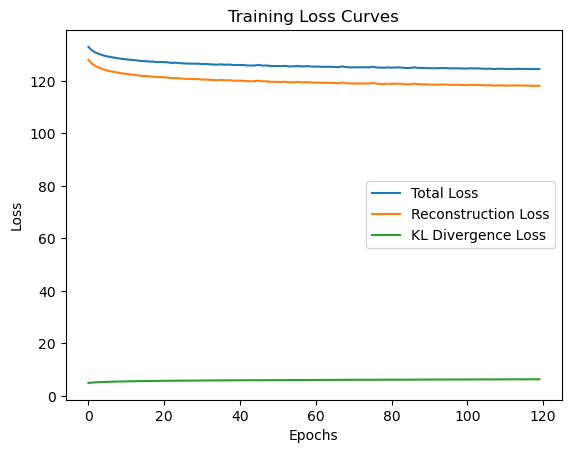

1875/1875 [==============================] - 3s 914us/step


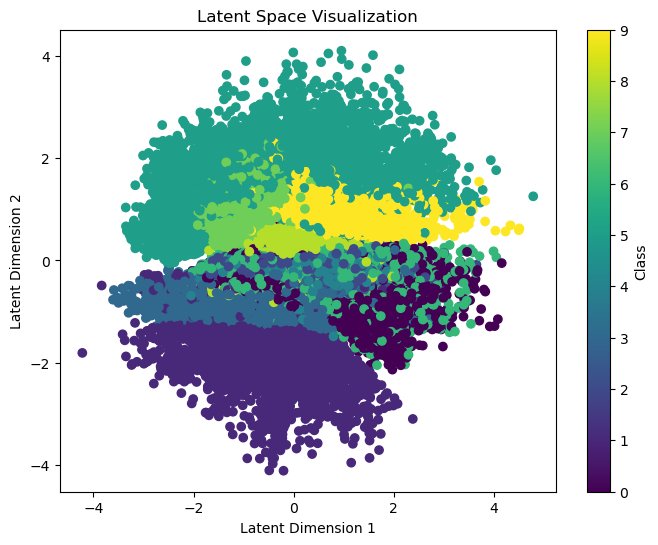

In [175]:
# Plot loss curves
plt.plot(history.history['total_loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()

# Visualize latent space
_, _, latent_points = vae.encoder.predict(x_train)
plt.figure(figsize=(8, 6))
plt.scatter(latent_points[:, 0], latent_points[:, 1], c=train_y, cmap='viridis')
plt.colorbar(label='Class')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

# VAE Reconstructions 🧱

157/157 [==============================] - 1s 7ms/step
Example real clothing items


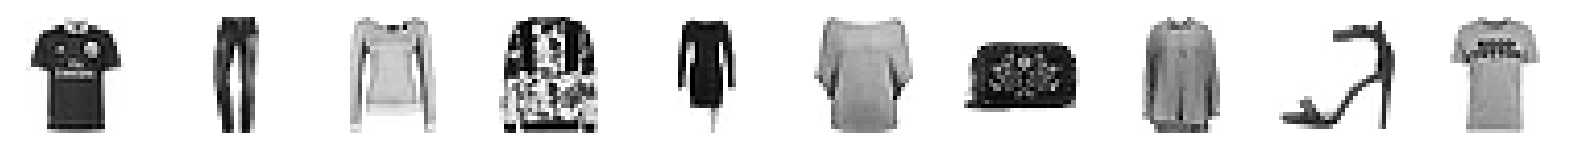

Reconstructions


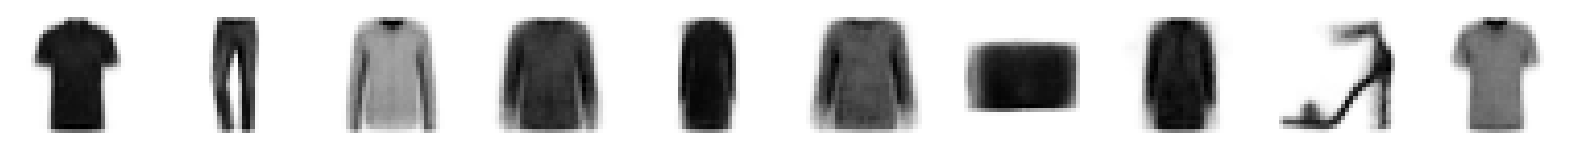

In [179]:
n_pred = 5000
example_images = x_test[:n_pred]
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

# Generating new samples using the VAE 🆕


In [177]:
z_mean, z_var, z = encoder.predict(example_images)
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
# Decode the sampled points
reconstructions = decoder.predict(z_sample)
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

1/1 [==============================] - 0s 161ms/step


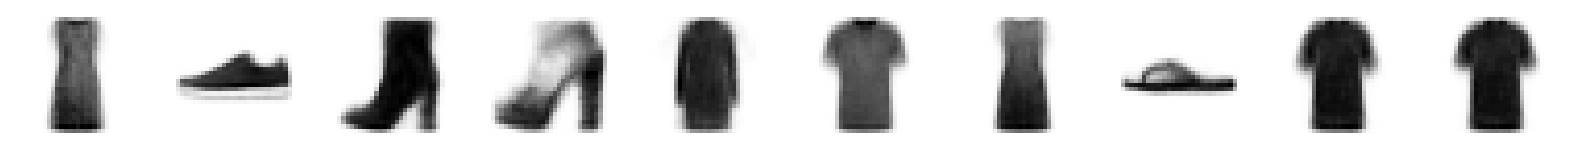

In [178]:
#Show New generated images 
display(reconstructions)

# 2. WGAN-GP model Building 🏗

In [64]:
latent_dim = 64
CHANNELS = 1
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
GP_WEIGHT = 5.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
SIZE = 32
CRITIC_LR = 0.000045 
GENERATOR_LR = 0.0002
CRITIC_STEPS = 1  


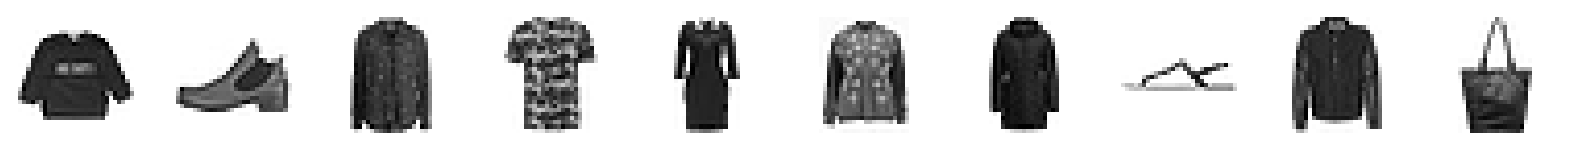

In [65]:
display(x_train)


In [66]:
critic_input = layers.Input(shape=(32, 32, 1))  # Update this to match your image dimensions
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
critic_output = layers.Dense(1)(x)
critic = models.Model(critic_input, critic_output)

In [67]:
# Enable mixed precision training
if tf.config.list_physical_devices('GPU'):
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled')

# Define the generator model
latent_dim = 64  # Update this to match your latent space dimension

generator_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 256, use_bias=False)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((8, 8, 256))(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
generator_output = layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation="tanh")(x)
generator_output = layers.Activation('tanh', dtype='float32')(generator_output)
generator = models.Model(generator_input, generator_output)

Mixed precision enabled


In [68]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight, **kwargs):
        super(WGANGP, self).__init__(**kwargs)
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def get_config(self):
        config = super(WGANGP, self).get_config()
        config.update({
            'critic': self.critic,
            'generator': self.generator,
            'latent_dim': self.latent_dim,
            'critic_steps': self.critic_steps,
            'gp_weight': self.gp_weight
        })
        return config

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Cast tensors to the same type
        real_images = tf.cast(real_images, tf.float32)
        fake_images = tf.cast(fake_images, tf.float32)
        
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp


    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)

                c_loss = c_wass_loss + tf.cast(c_gp, c_wass_loss.dtype) * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        # self.history['c_loss'].append(float(self.c_loss_metric.result()))
        # self.history['c_wass_loss'].append(float(self.c_wass_loss_metric.result()))
        # self.history['c_gp'].append(float(self.c_gp_metric.result()))
        # self.history['g_loss'].append(float(self.g_loss_metric.result()))

        return {m.name: m.result() for m in self.metrics}

In [69]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=latent_dim,
    critic_steps=2,
    gp_weight=GP_WEIGHT,
)

In [70]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=CRITIC_LR, beta_1=0.5, beta_2=0.9),
    g_optimizer=optimizers.Adam(learning_rate=GENERATOR_LR, beta_1=0.5, beta_2=0.9),
)

In [71]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.keras",  # Adjust the filepath as needed
    save_weights_only=False,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

training_metrics = {
    "c_loss": [],
    "c_wass_loss": [],
    "c_gp": [],
    "g_loss": []
}


class MetricsHistory(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        training_metrics['c_loss'].append(logs.get('c_loss'))
        training_metrics['c_wass_loss'].append(logs.get('c_wass_loss'))
        training_metrics['c_gp'].append(logs.get('c_gp'))
        training_metrics['g_loss'].append(logs.get('g_loss'))


metrics_history_callback = MetricsHistory()

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()

        # Create the directory if it doesn't exist
        save_path = f"./generated_images/{epoch}"
        os.makedirs(save_path, exist_ok=True)

        display(
            generated_images,
            save_to=f"{save_path}/image.png",  # Change save path
            cmap=None,
        )

def scheduler(epoch, lr):
    if epoch < 1000:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = callbacks.LearningRateScheduler(scheduler)

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

augmented_x_train = data_augmentation(x_train)

        

Epoch 1/50
  6/937 [..............................] - ETA: 1:36 - c_loss: -0.2660 - c_wass_loss: -0.3947 - c_gp: 0.0257 - g_loss: 1.8055WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0918s vs `on_train_batch_end` time: 0.2403s). Check your callbacks.


937/937 [==============================] - ETA: 0s - c_loss: -0.3693 - c_wass_loss: -0.4487 - c_gp: 0.0159 - g_loss: -5.0096

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)



Saved to ./generated_images/0/image.png


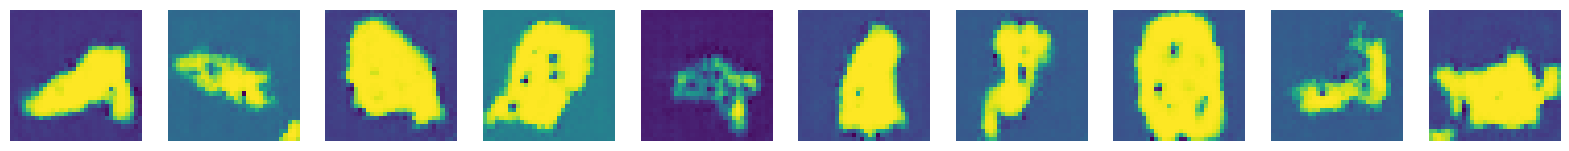

937/937 [==============================] - 94s 99ms/step - c_loss: -0.3693 - c_wass_loss: -0.4487 - c_gp: 0.0159 - g_loss: -5.0096 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - ETA: 0s - c_loss: -0.5064 - c_wass_loss: -0.5848 - c_gp: 0.0157 - g_loss: -9.1592
Saved to ./generated_images/1/image.png


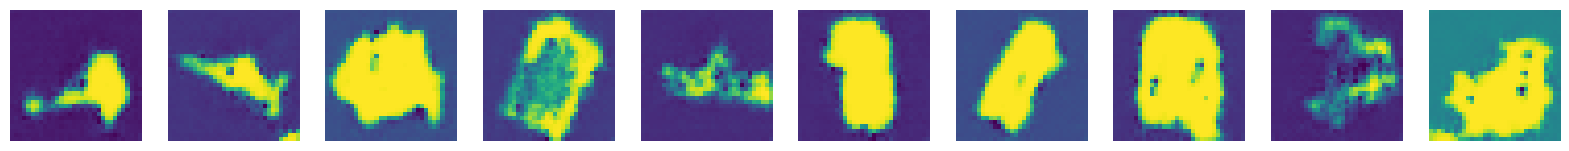

937/937 [==============================] - 91s 97ms/step - c_loss: -0.5064 - c_wass_loss: -0.5848 - c_gp: 0.0157 - g_loss: -9.1592 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - ETA: 0s - c_loss: -0.5794 - c_wass_loss: -0.6646 - c_gp: 0.0170 - g_loss: -8.6736
Saved to ./generated_images/2/image.png


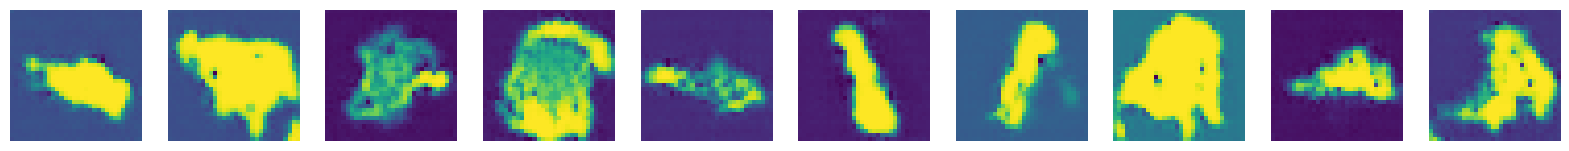

937/937 [==============================] - 90s 96ms/step - c_loss: -0.5794 - c_wass_loss: -0.6646 - c_gp: 0.0170 - g_loss: -8.6736 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - ETA: 0s - c_loss: -0.6350 - c_wass_loss: -0.7285 - c_gp: 0.0187 - g_loss: -8.3596
Saved to ./generated_images/3/image.png


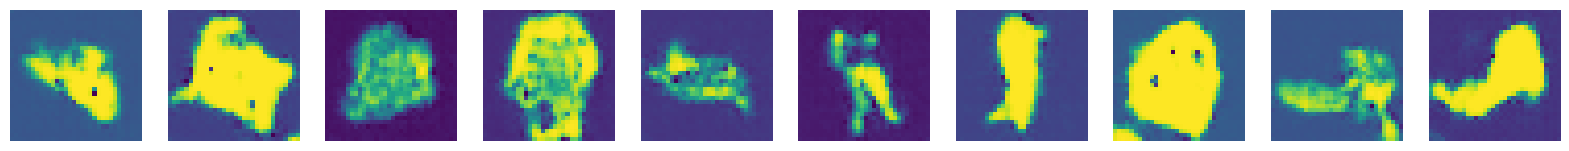

937/937 [==============================] - 92s 98ms/step - c_loss: -0.6350 - c_wass_loss: -0.7285 - c_gp: 0.0187 - g_loss: -8.3596 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - ETA: 0s - c_loss: -0.6924 - c_wass_loss: -0.7984 - c_gp: 0.0212 - g_loss: -8.7948
Saved to ./generated_images/4/image.png


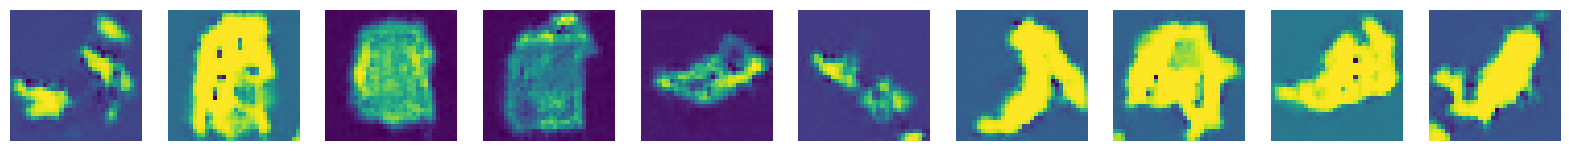

937/937 [==============================] - 90s 96ms/step - c_loss: -0.6924 - c_wass_loss: -0.7984 - c_gp: 0.0212 - g_loss: -8.7948 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - ETA: 0s - c_loss: -0.7552 - c_wass_loss: -0.8698 - c_gp: 0.0229 - g_loss: -7.8247
Saved to ./generated_images/5/image.png


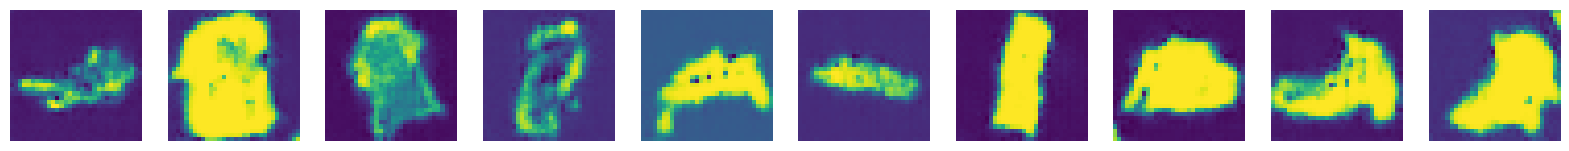

937/937 [==============================] - 89s 95ms/step - c_loss: -0.7552 - c_wass_loss: -0.8698 - c_gp: 0.0229 - g_loss: -7.8247 - lr: 0.0010
Epoch 7/50
937/937 [==============================] - ETA: 0s - c_loss: -0.7977 - c_wass_loss: -0.9216 - c_gp: 0.0248 - g_loss: -7.3168
Saved to ./generated_images/6/image.png


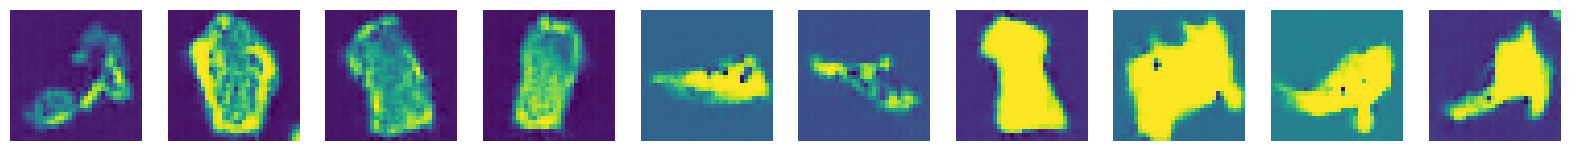

937/937 [==============================] - 89s 95ms/step - c_loss: -0.7977 - c_wass_loss: -0.9216 - c_gp: 0.0248 - g_loss: -7.3168 - lr: 0.0010
Epoch 8/50
937/937 [==============================] - ETA: 0s - c_loss: -0.8404 - c_wass_loss: -0.9711 - c_gp: 0.0261 - g_loss: -6.7932
Saved to ./generated_images/7/image.png


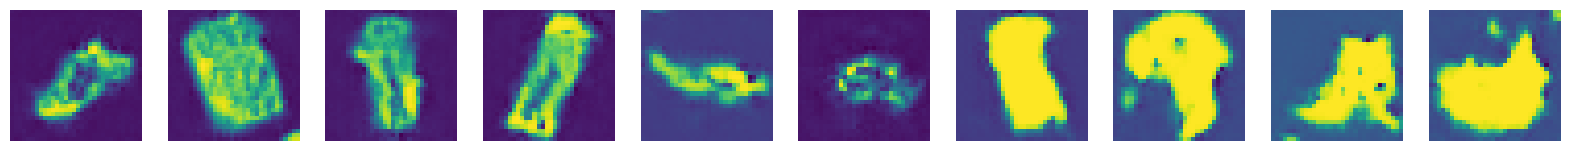

937/937 [==============================] - 90s 96ms/step - c_loss: -0.8404 - c_wass_loss: -0.9711 - c_gp: 0.0261 - g_loss: -6.7932 - lr: 0.0010
Epoch 9/50
937/937 [==============================] - ETA: 0s - c_loss: -0.8851 - c_wass_loss: -1.0190 - c_gp: 0.0268 - g_loss: -6.3477
Saved to ./generated_images/8/image.png


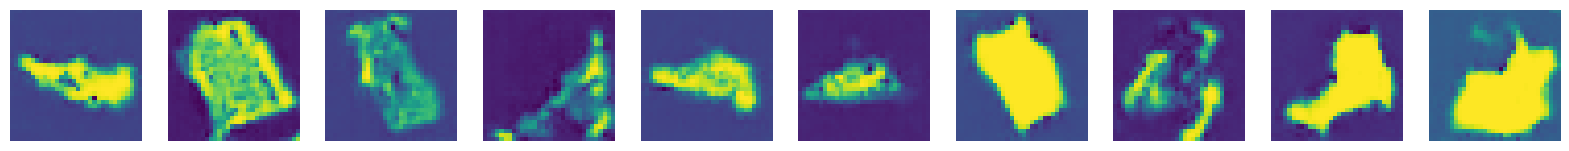

937/937 [==============================] - 89s 95ms/step - c_loss: -0.8851 - c_wass_loss: -1.0190 - c_gp: 0.0268 - g_loss: -6.3477 - lr: 0.0010
Epoch 10/50
937/937 [==============================] - ETA: 0s - c_loss: -0.8948 - c_wass_loss: -1.0296 - c_gp: 0.0270 - g_loss: -6.6477
Saved to ./generated_images/9/image.png


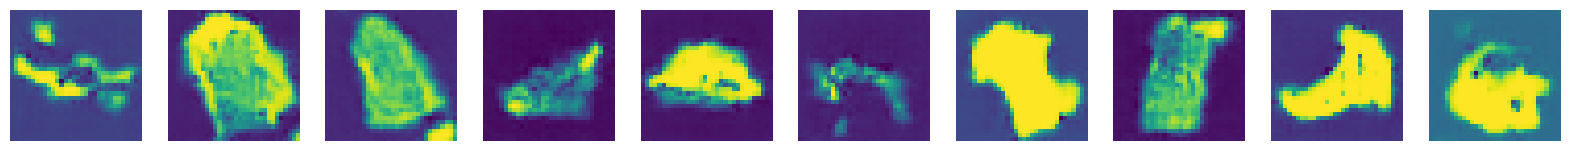

937/937 [==============================] - 90s 96ms/step - c_loss: -0.8948 - c_wass_loss: -1.0296 - c_gp: 0.0270 - g_loss: -6.6477 - lr: 0.0010
Epoch 11/50
937/937 [==============================] - ETA: 0s - c_loss: -0.9210 - c_wass_loss: -1.0481 - c_gp: 0.0254 - g_loss: -5.9590
Saved to ./generated_images/10/image.png


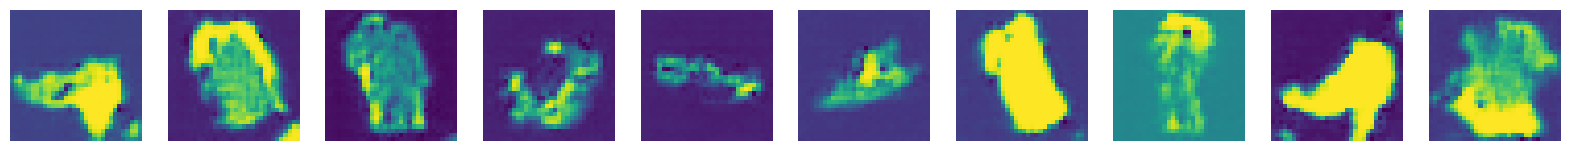

937/937 [==============================] - 90s 96ms/step - c_loss: -0.9210 - c_wass_loss: -1.0481 - c_gp: 0.0254 - g_loss: -5.9590 - lr: 0.0010
Epoch 12/50
937/937 [==============================] - ETA: 0s - c_loss: -1.0142 - c_wass_loss: -1.1529 - c_gp: 0.0277 - g_loss: -5.3296
Saved to ./generated_images/11/image.png


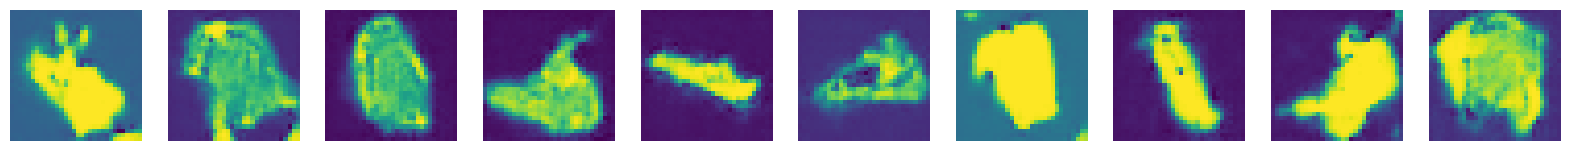

937/937 [==============================] - 90s 96ms/step - c_loss: -1.0142 - c_wass_loss: -1.1529 - c_gp: 0.0277 - g_loss: -5.3296 - lr: 0.0010
Epoch 13/50
937/937 [==============================] - ETA: 0s - c_loss: -1.0505 - c_wass_loss: -1.1981 - c_gp: 0.0295 - g_loss: -4.6870
Saved to ./generated_images/12/image.png


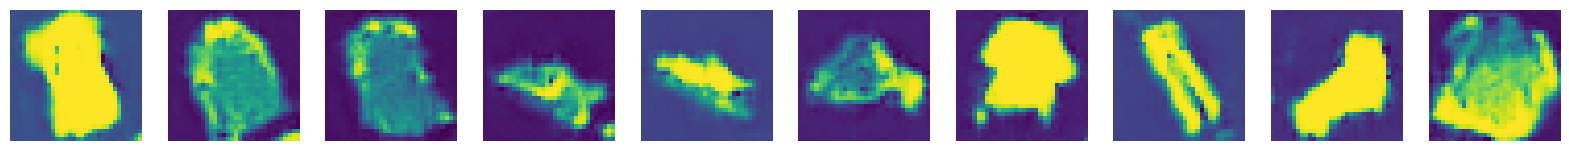

937/937 [==============================] - 89s 95ms/step - c_loss: -1.0505 - c_wass_loss: -1.1981 - c_gp: 0.0295 - g_loss: -4.6870 - lr: 0.0010
Epoch 14/50
937/937 [==============================] - ETA: 0s - c_loss: -1.0795 - c_wass_loss: -1.2355 - c_gp: 0.0312 - g_loss: -3.3766
Saved to ./generated_images/13/image.png


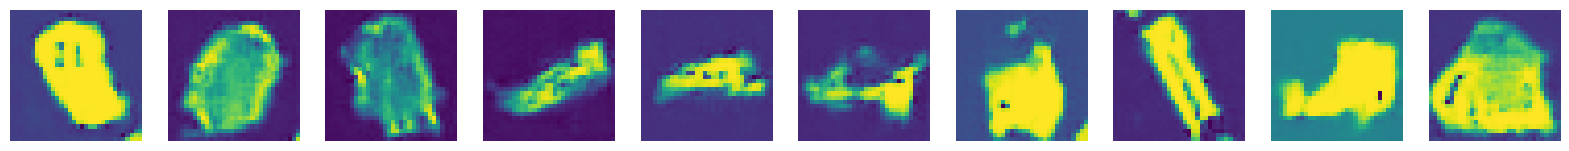

937/937 [==============================] - 91s 97ms/step - c_loss: -1.0795 - c_wass_loss: -1.2355 - c_gp: 0.0312 - g_loss: -3.3766 - lr: 0.0010
Epoch 15/50
937/937 [==============================] - ETA: 0s - c_loss: -1.1049 - c_wass_loss: -1.2614 - c_gp: 0.0313 - g_loss: -3.8775
Saved to ./generated_images/14/image.png


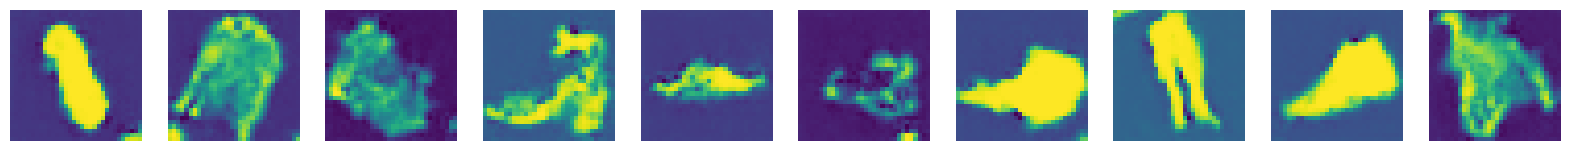

937/937 [==============================] - 91s 97ms/step - c_loss: -1.1049 - c_wass_loss: -1.2614 - c_gp: 0.0313 - g_loss: -3.8775 - lr: 0.0010
Epoch 16/50
937/937 [==============================] - ETA: 0s - c_loss: -1.1198 - c_wass_loss: -1.2782 - c_gp: 0.0317 - g_loss: -3.0766
Saved to ./generated_images/15/image.png


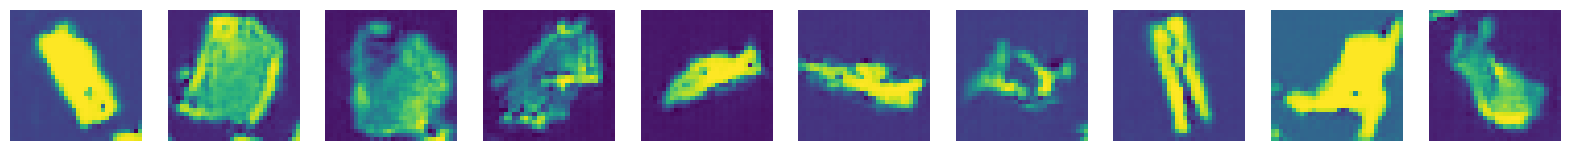

937/937 [==============================] - 90s 96ms/step - c_loss: -1.1198 - c_wass_loss: -1.2782 - c_gp: 0.0317 - g_loss: -3.0766 - lr: 0.0010
Epoch 17/50
937/937 [==============================] - ETA: 0s - c_loss: -1.1313 - c_wass_loss: -1.2946 - c_gp: 0.0327 - g_loss: -3.0061
Saved to ./generated_images/16/image.png


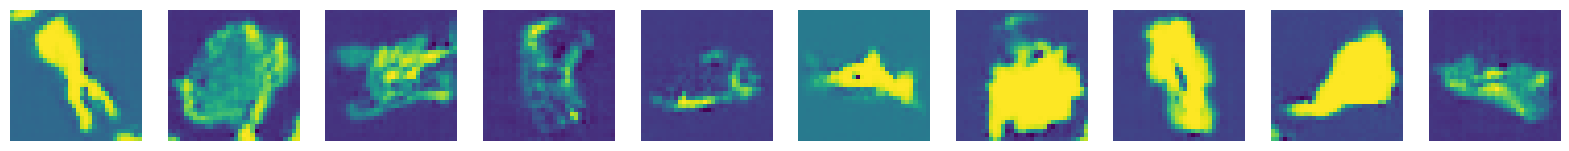

937/937 [==============================] - 90s 96ms/step - c_loss: -1.1313 - c_wass_loss: -1.2946 - c_gp: 0.0327 - g_loss: -3.0061 - lr: 0.0010
Epoch 18/50
937/937 [==============================] - ETA: 0s - c_loss: -1.1582 - c_wass_loss: -1.3242 - c_gp: 0.0332 - g_loss: -2.5533
Saved to ./generated_images/17/image.png


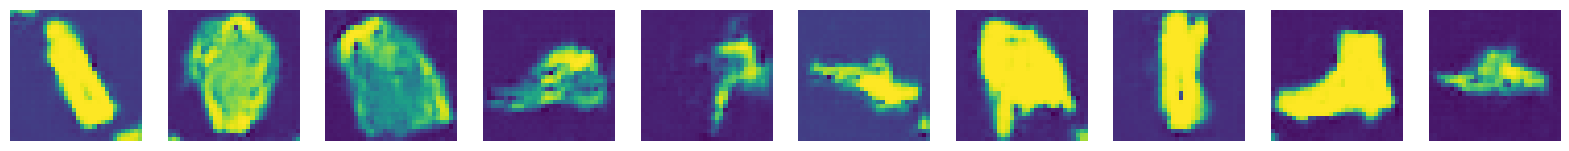

937/937 [==============================] - 91s 97ms/step - c_loss: -1.1582 - c_wass_loss: -1.3242 - c_gp: 0.0332 - g_loss: -2.5533 - lr: 0.0010
Epoch 19/50
937/937 [==============================] - ETA: 0s - c_loss: -1.1694 - c_wass_loss: -1.3376 - c_gp: 0.0336 - g_loss: -2.6163
Saved to ./generated_images/18/image.png


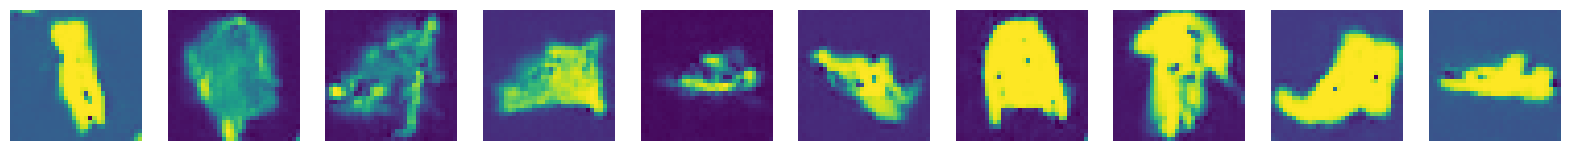

937/937 [==============================] - 91s 97ms/step - c_loss: -1.1694 - c_wass_loss: -1.3376 - c_gp: 0.0336 - g_loss: -2.6163 - lr: 0.0010
Epoch 20/50
937/937 [==============================] - ETA: 0s - c_loss: -1.1766 - c_wass_loss: -1.3492 - c_gp: 0.0345 - g_loss: -3.0528
Saved to ./generated_images/19/image.png


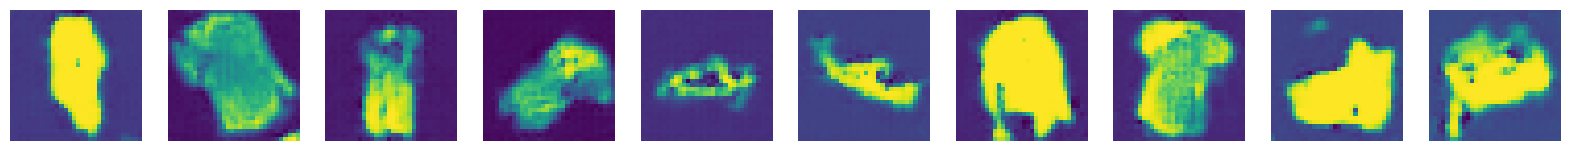

937/937 [==============================] - 90s 97ms/step - c_loss: -1.1766 - c_wass_loss: -1.3492 - c_gp: 0.0345 - g_loss: -3.0528 - lr: 0.0010
Epoch 21/50
937/937 [==============================] - ETA: 0s - c_loss: -1.2306 - c_wass_loss: -1.4179 - c_gp: 0.0374 - g_loss: -2.5028
Saved to ./generated_images/20/image.png


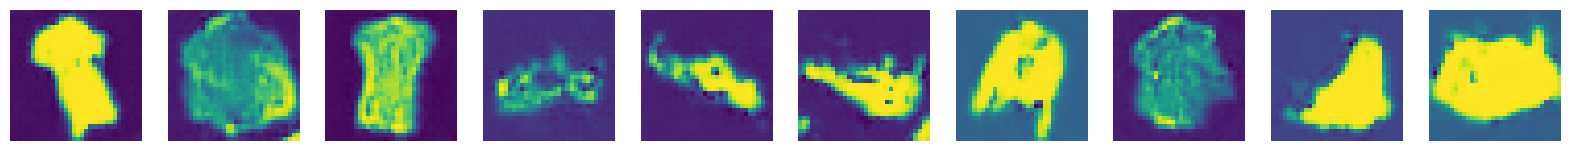

937/937 [==============================] - 90s 96ms/step - c_loss: -1.2306 - c_wass_loss: -1.4179 - c_gp: 0.0374 - g_loss: -2.5028 - lr: 0.0010
Epoch 22/50
937/937 [==============================] - ETA: 0s - c_loss: -1.2235 - c_wass_loss: -1.4071 - c_gp: 0.0367 - g_loss: -3.4975
Saved to ./generated_images/21/image.png


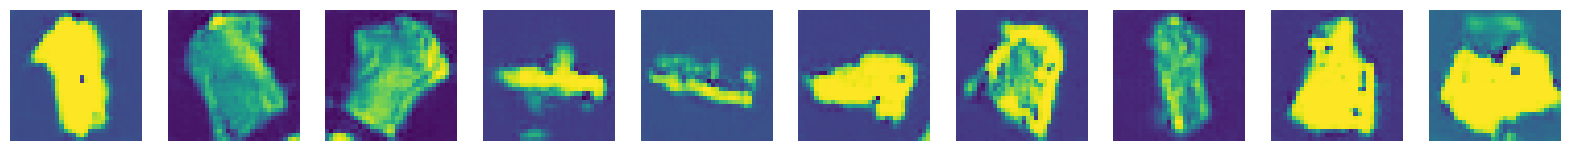

937/937 [==============================] - 90s 96ms/step - c_loss: -1.2235 - c_wass_loss: -1.4071 - c_gp: 0.0367 - g_loss: -3.4975 - lr: 0.0010
Epoch 23/50
937/937 [==============================] - ETA: 0s - c_loss: -1.2719 - c_wass_loss: -1.4533 - c_gp: 0.0363 - g_loss: -3.8662
Saved to ./generated_images/22/image.png


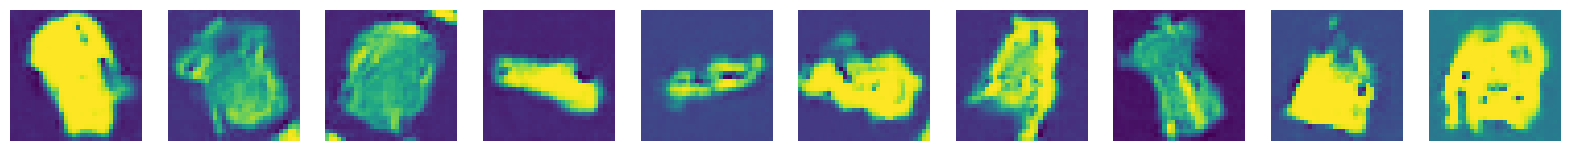

937/937 [==============================] - 91s 97ms/step - c_loss: -1.2719 - c_wass_loss: -1.4533 - c_gp: 0.0363 - g_loss: -3.8662 - lr: 0.0010
Epoch 24/50
937/937 [==============================] - ETA: 0s - c_loss: -1.2937 - c_wass_loss: -1.4908 - c_gp: 0.0394 - g_loss: -3.8584
Saved to ./generated_images/23/image.png


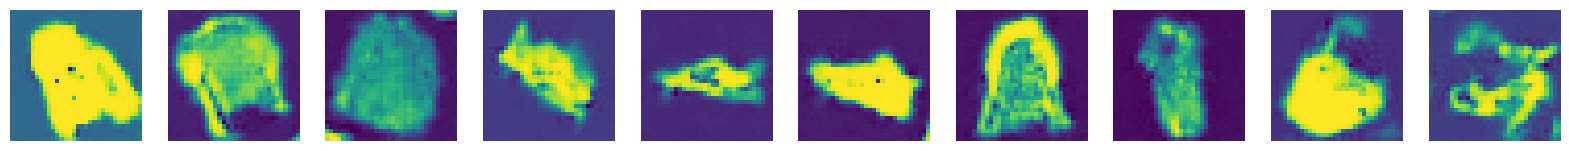

937/937 [==============================] - 91s 97ms/step - c_loss: -1.2937 - c_wass_loss: -1.4908 - c_gp: 0.0394 - g_loss: -3.8584 - lr: 0.0010
Epoch 25/50
937/937 [==============================] - ETA: 0s - c_loss: -1.2982 - c_wass_loss: -1.4951 - c_gp: 0.0394 - g_loss: -3.3614
Saved to ./generated_images/24/image.png


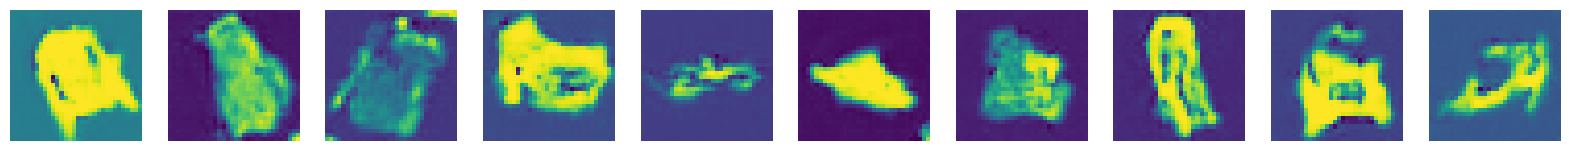

937/937 [==============================] - 90s 96ms/step - c_loss: -1.2982 - c_wass_loss: -1.4951 - c_gp: 0.0394 - g_loss: -3.3614 - lr: 0.0010
Epoch 26/50
937/937 [==============================] - ETA: 0s - c_loss: -1.2722 - c_wass_loss: -1.4627 - c_gp: 0.0381 - g_loss: -4.3425
Saved to ./generated_images/25/image.png


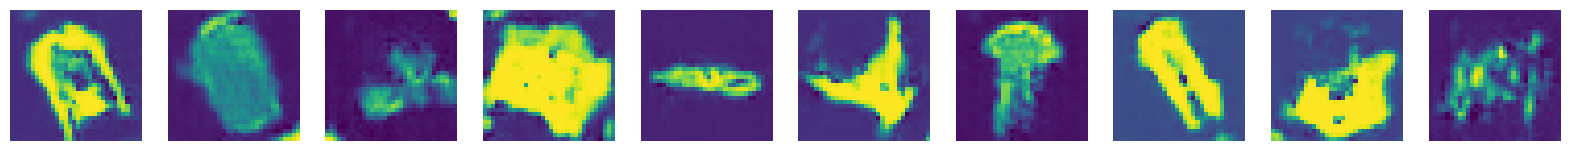

937/937 [==============================] - 90s 96ms/step - c_loss: -1.2722 - c_wass_loss: -1.4627 - c_gp: 0.0381 - g_loss: -4.3425 - lr: 0.0010
Epoch 27/50
937/937 [==============================] - ETA: 0s - c_loss: -1.3616 - c_wass_loss: -1.5558 - c_gp: 0.0388 - g_loss: -5.0836
Saved to ./generated_images/26/image.png


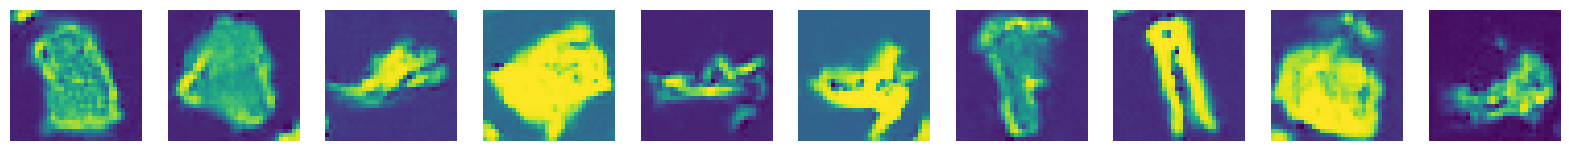

937/937 [==============================] - 90s 96ms/step - c_loss: -1.3616 - c_wass_loss: -1.5558 - c_gp: 0.0388 - g_loss: -5.0836 - lr: 0.0010
Epoch 28/50
937/937 [==============================] - ETA: 0s - c_loss: -1.3527 - c_wass_loss: -1.5541 - c_gp: 0.0403 - g_loss: -6.3464
Saved to ./generated_images/27/image.png


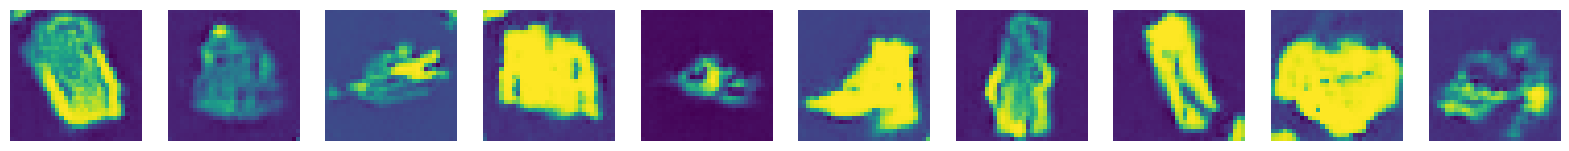

937/937 [==============================] - 90s 96ms/step - c_loss: -1.3527 - c_wass_loss: -1.5541 - c_gp: 0.0403 - g_loss: -6.3464 - lr: 0.0010
Epoch 29/50
937/937 [==============================] - ETA: 0s - c_loss: -1.3499 - c_wass_loss: -1.5359 - c_gp: 0.0372 - g_loss: -7.0443
Saved to ./generated_images/28/image.png


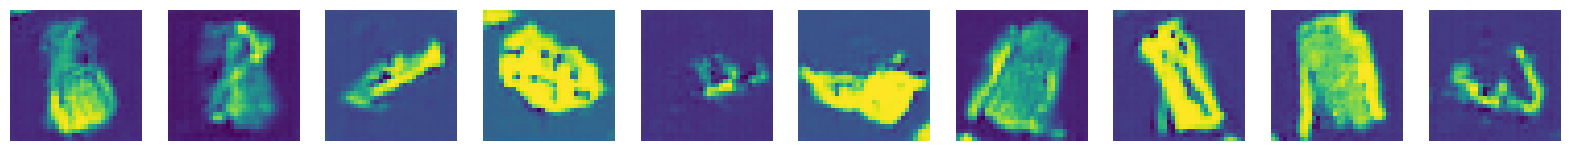

937/937 [==============================] - 90s 96ms/step - c_loss: -1.3499 - c_wass_loss: -1.5359 - c_gp: 0.0372 - g_loss: -7.0443 - lr: 0.0010
Epoch 30/50
937/937 [==============================] - ETA: 0s - c_loss: -1.4162 - c_wass_loss: -1.6187 - c_gp: 0.0405 - g_loss: -7.5907
Saved to ./generated_images/29/image.png


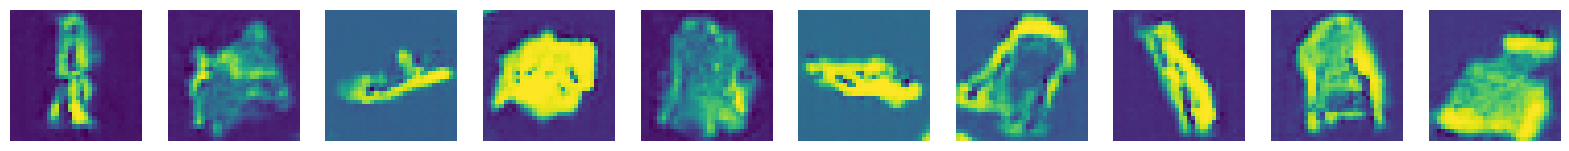

937/937 [==============================] - 90s 97ms/step - c_loss: -1.4162 - c_wass_loss: -1.6187 - c_gp: 0.0405 - g_loss: -7.5907 - lr: 0.0010
Epoch 31/50
937/937 [==============================] - ETA: 0s - c_loss: -1.4018 - c_wass_loss: -1.6071 - c_gp: 0.0411 - g_loss: -8.5703
Saved to ./generated_images/30/image.png


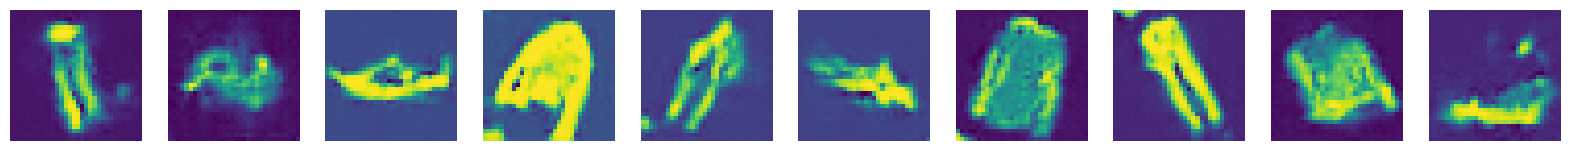

937/937 [==============================] - 93s 99ms/step - c_loss: -1.4018 - c_wass_loss: -1.6071 - c_gp: 0.0411 - g_loss: -8.5703 - lr: 0.0010
Epoch 32/50
937/937 [==============================] - ETA: 0s - c_loss: -1.4372 - c_wass_loss: -1.6479 - c_gp: 0.0421 - g_loss: -7.1441
Saved to ./generated_images/31/image.png


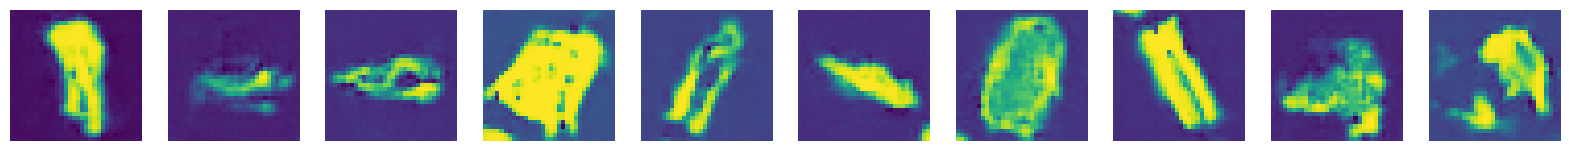

937/937 [==============================] - 92s 98ms/step - c_loss: -1.4372 - c_wass_loss: -1.6479 - c_gp: 0.0421 - g_loss: -7.1441 - lr: 0.0010
Epoch 33/50
937/937 [==============================] - ETA: 0s - c_loss: -1.4323 - c_wass_loss: -1.6550 - c_gp: 0.0445 - g_loss: -4.9607
Saved to ./generated_images/32/image.png


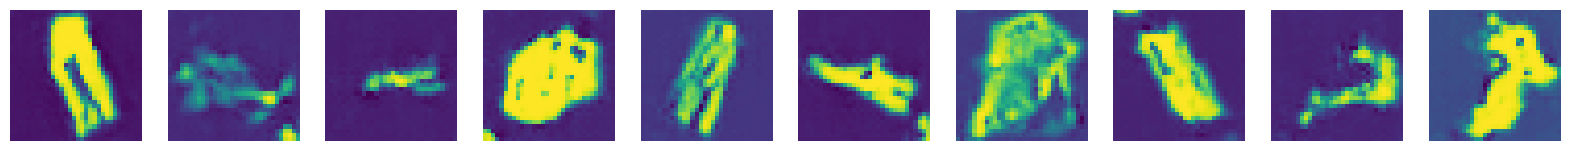

937/937 [==============================] - 90s 97ms/step - c_loss: -1.4323 - c_wass_loss: -1.6550 - c_gp: 0.0445 - g_loss: -4.9607 - lr: 0.0010
Epoch 34/50
937/937 [==============================] - ETA: 0s - c_loss: -1.4522 - c_wass_loss: -1.6733 - c_gp: 0.0442 - g_loss: -6.8499
Saved to ./generated_images/33/image.png


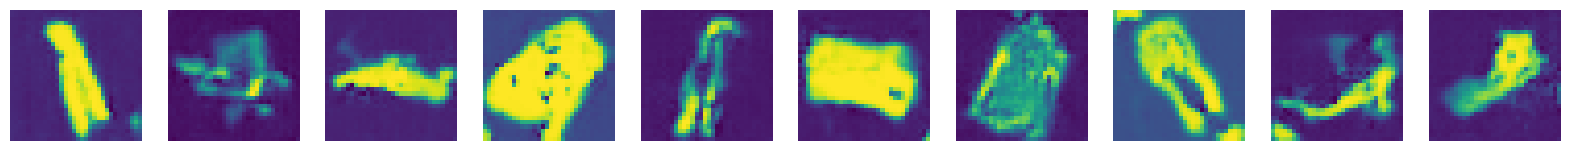

937/937 [==============================] - 90s 96ms/step - c_loss: -1.4522 - c_wass_loss: -1.6733 - c_gp: 0.0442 - g_loss: -6.8499 - lr: 0.0010
Epoch 35/50
937/937 [==============================] - ETA: 0s - c_loss: -1.4772 - c_wass_loss: -1.6947 - c_gp: 0.0435 - g_loss: -6.8921
Saved to ./generated_images/34/image.png


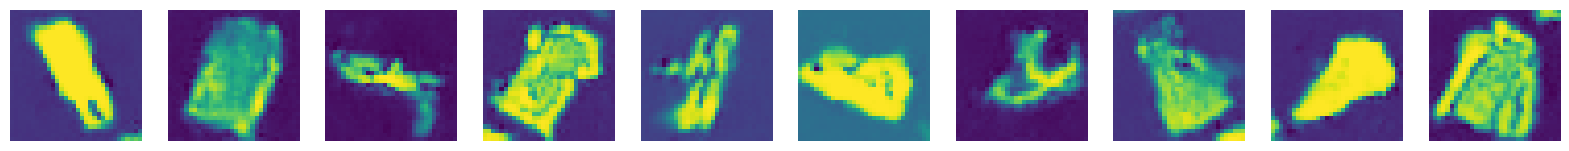

937/937 [==============================] - 90s 96ms/step - c_loss: -1.4772 - c_wass_loss: -1.6947 - c_gp: 0.0435 - g_loss: -6.8921 - lr: 0.0010
Epoch 36/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5534 - c_wass_loss: -1.7893 - c_gp: 0.0472 - g_loss: -6.6019
Saved to ./generated_images/35/image.png


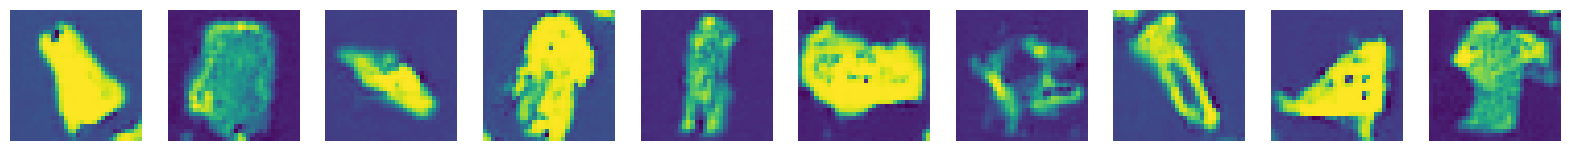

937/937 [==============================] - 91s 97ms/step - c_loss: -1.5534 - c_wass_loss: -1.7893 - c_gp: 0.0472 - g_loss: -6.6019 - lr: 0.0010
Epoch 37/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5296 - c_wass_loss: -1.7615 - c_gp: 0.0464 - g_loss: -5.9056
Saved to ./generated_images/36/image.png


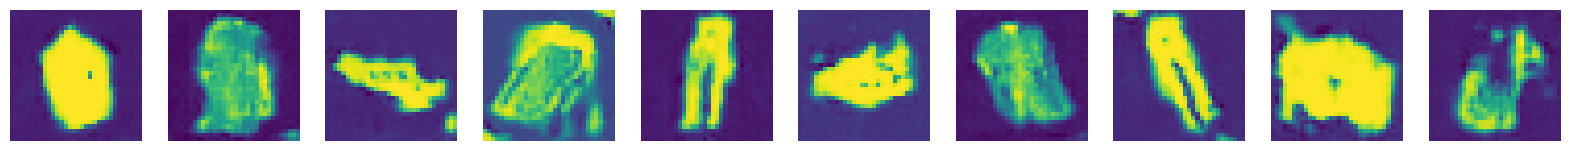

937/937 [==============================] - 90s 96ms/step - c_loss: -1.5296 - c_wass_loss: -1.7615 - c_gp: 0.0464 - g_loss: -5.9056 - lr: 0.0010
Epoch 38/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5432 - c_wass_loss: -1.7769 - c_gp: 0.0467 - g_loss: -4.6751
Saved to ./generated_images/37/image.png


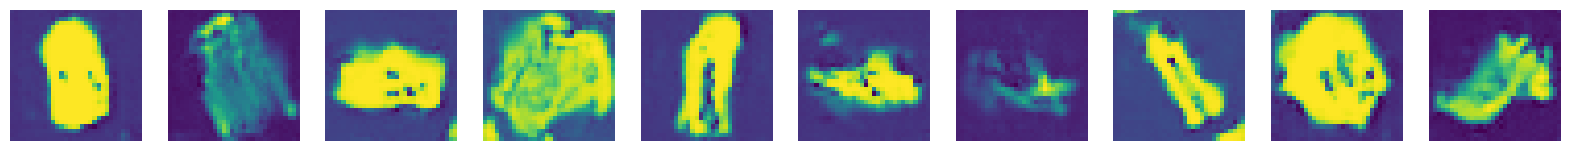

937/937 [==============================] - 90s 96ms/step - c_loss: -1.5432 - c_wass_loss: -1.7769 - c_gp: 0.0467 - g_loss: -4.6751 - lr: 0.0010
Epoch 39/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5580 - c_wass_loss: -1.7938 - c_gp: 0.0472 - g_loss: -4.9314
Saved to ./generated_images/38/image.png


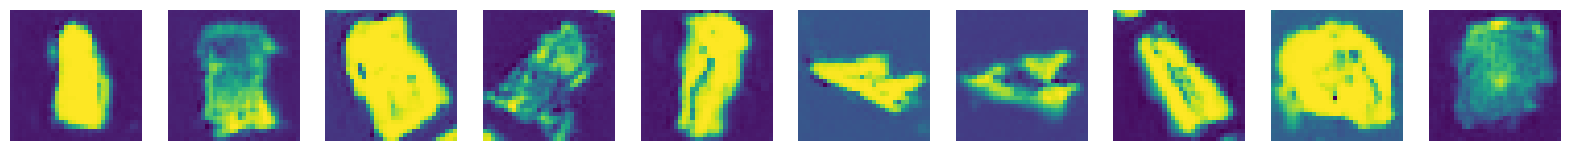

937/937 [==============================] - 90s 96ms/step - c_loss: -1.5580 - c_wass_loss: -1.7938 - c_gp: 0.0472 - g_loss: -4.9314 - lr: 0.0010
Epoch 40/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5687 - c_wass_loss: -1.7984 - c_gp: 0.0459 - g_loss: -4.7176
Saved to ./generated_images/39/image.png


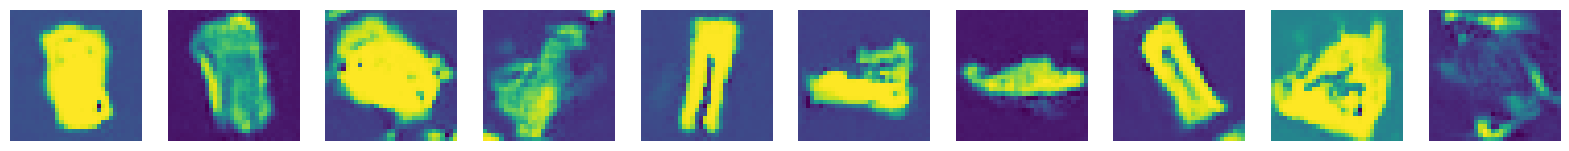

937/937 [==============================] - 90s 97ms/step - c_loss: -1.5687 - c_wass_loss: -1.7984 - c_gp: 0.0459 - g_loss: -4.7176 - lr: 0.0010
Epoch 41/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5402 - c_wass_loss: -1.7717 - c_gp: 0.0463 - g_loss: -4.1740
Saved to ./generated_images/40/image.png


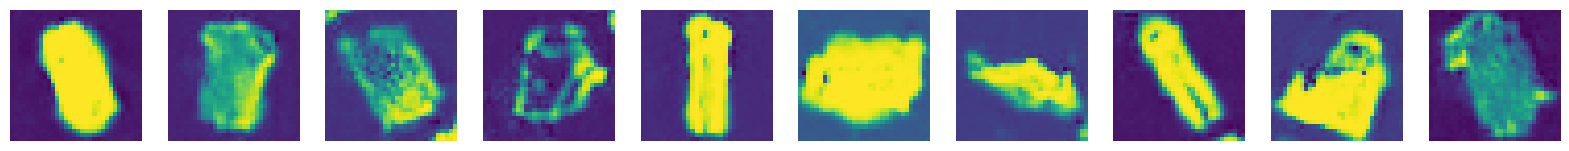

937/937 [==============================] - 90s 96ms/step - c_loss: -1.5402 - c_wass_loss: -1.7717 - c_gp: 0.0463 - g_loss: -4.1740 - lr: 0.0010
Epoch 42/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5295 - c_wass_loss: -1.7627 - c_gp: 0.0466 - g_loss: -3.9376
Saved to ./generated_images/41/image.png


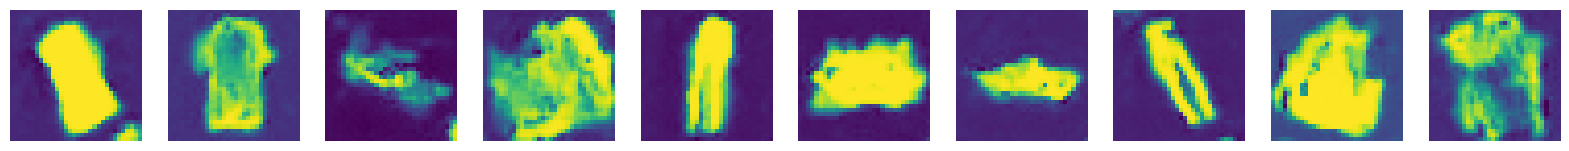

937/937 [==============================] - 90s 96ms/step - c_loss: -1.5295 - c_wass_loss: -1.7627 - c_gp: 0.0466 - g_loss: -3.9376 - lr: 0.0010
Epoch 43/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5161 - c_wass_loss: -1.7417 - c_gp: 0.0451 - g_loss: -3.1053
Saved to ./generated_images/42/image.png


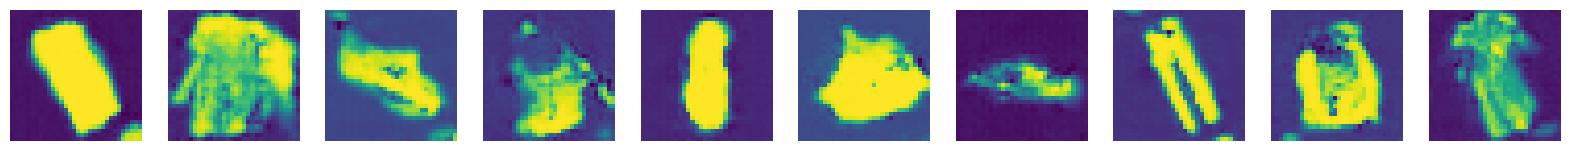

937/937 [==============================] - 92s 98ms/step - c_loss: -1.5161 - c_wass_loss: -1.7417 - c_gp: 0.0451 - g_loss: -3.1053 - lr: 0.0010
Epoch 44/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5696 - c_wass_loss: -1.8029 - c_gp: 0.0467 - g_loss: -3.3643
Saved to ./generated_images/43/image.png


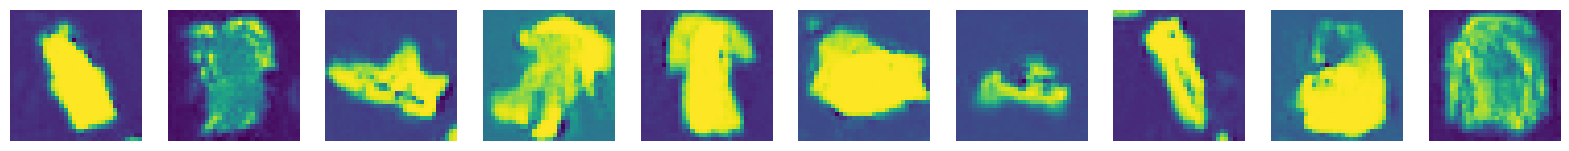

937/937 [==============================] - 91s 97ms/step - c_loss: -1.5696 - c_wass_loss: -1.8029 - c_gp: 0.0467 - g_loss: -3.3643 - lr: 0.0010
Epoch 45/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5287 - c_wass_loss: -1.7635 - c_gp: 0.0470 - g_loss: -2.3875
Saved to ./generated_images/44/image.png


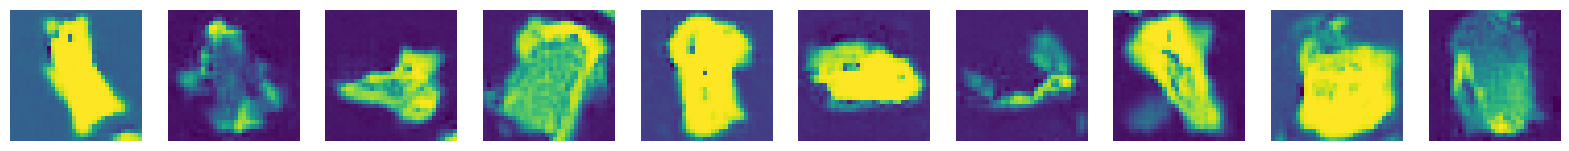

937/937 [==============================] - 90s 96ms/step - c_loss: -1.5287 - c_wass_loss: -1.7635 - c_gp: 0.0470 - g_loss: -2.3875 - lr: 0.0010
Epoch 46/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5607 - c_wass_loss: -1.7893 - c_gp: 0.0457 - g_loss: -3.5253
Saved to ./generated_images/45/image.png


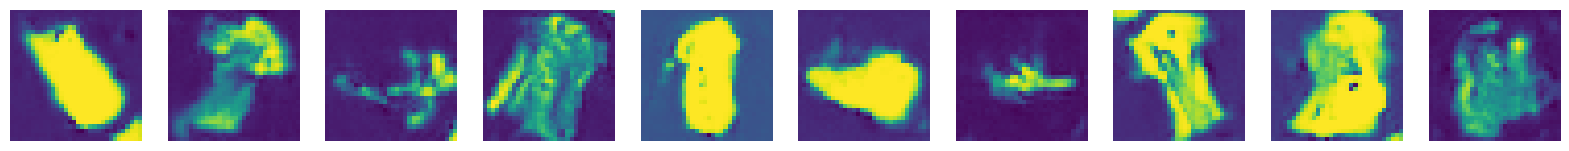

937/937 [==============================] - 90s 96ms/step - c_loss: -1.5607 - c_wass_loss: -1.7893 - c_gp: 0.0457 - g_loss: -3.5253 - lr: 0.0010
Epoch 47/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5454 - c_wass_loss: -1.7764 - c_gp: 0.0462 - g_loss: -3.0810
Saved to ./generated_images/46/image.png


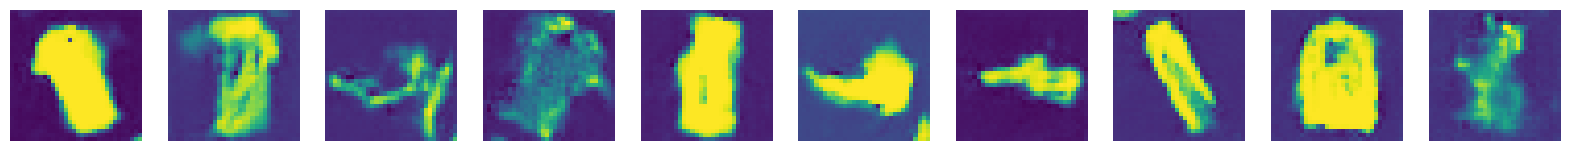

937/937 [==============================] - 88s 94ms/step - c_loss: -1.5454 - c_wass_loss: -1.7764 - c_gp: 0.0462 - g_loss: -3.0810 - lr: 0.0010
Epoch 48/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5536 - c_wass_loss: -1.7933 - c_gp: 0.0480 - g_loss: -2.4970
Saved to ./generated_images/47/image.png


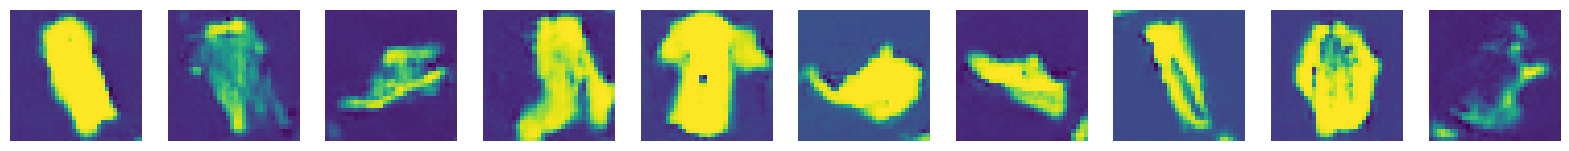

937/937 [==============================] - 94s 100ms/step - c_loss: -1.5536 - c_wass_loss: -1.7933 - c_gp: 0.0480 - g_loss: -2.4970 - lr: 0.0010
Epoch 49/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5479 - c_wass_loss: -1.7880 - c_gp: 0.0480 - g_loss: -1.7176
Saved to ./generated_images/48/image.png


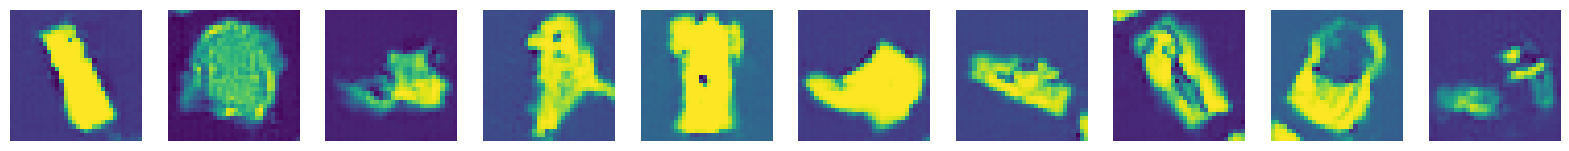

937/937 [==============================] - 94s 100ms/step - c_loss: -1.5479 - c_wass_loss: -1.7880 - c_gp: 0.0480 - g_loss: -1.7176 - lr: 0.0010
Epoch 50/50
937/937 [==============================] - ETA: 0s - c_loss: -1.5679 - c_wass_loss: -1.7969 - c_gp: 0.0458 - g_loss: -3.4696
Saved to ./generated_images/49/image.png


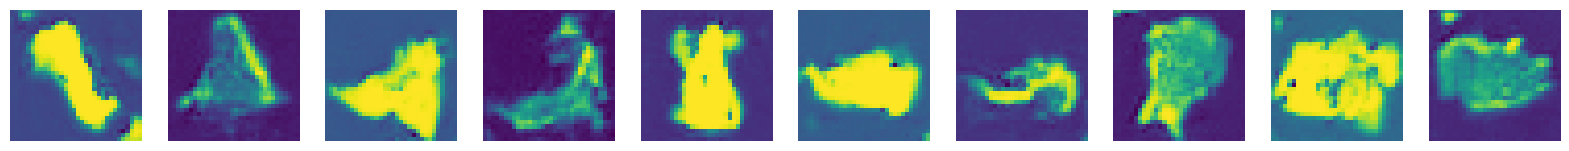

937/937 [==============================] - 89s 95ms/step - c_loss: -1.5679 - c_wass_loss: -1.7969 - c_gp: 0.0458 - g_loss: -3.4696 - lr: 0.0010


ValueError: Model <__main__.WGANGP object at 0x4682eeb30> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [74]:
BATCH_SIZE_WGAN = 64

steps_per_epoch = len(x_train) // BATCH_SIZE_WGAN

wgangp.fit(
    augmented_x_train,  
    epochs=50,
    batch_size=32,
    steps_per_epoch=steps_per_epoch,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=latent_dim),
        metrics_history_callback,
        lr_scheduler
    ],
)



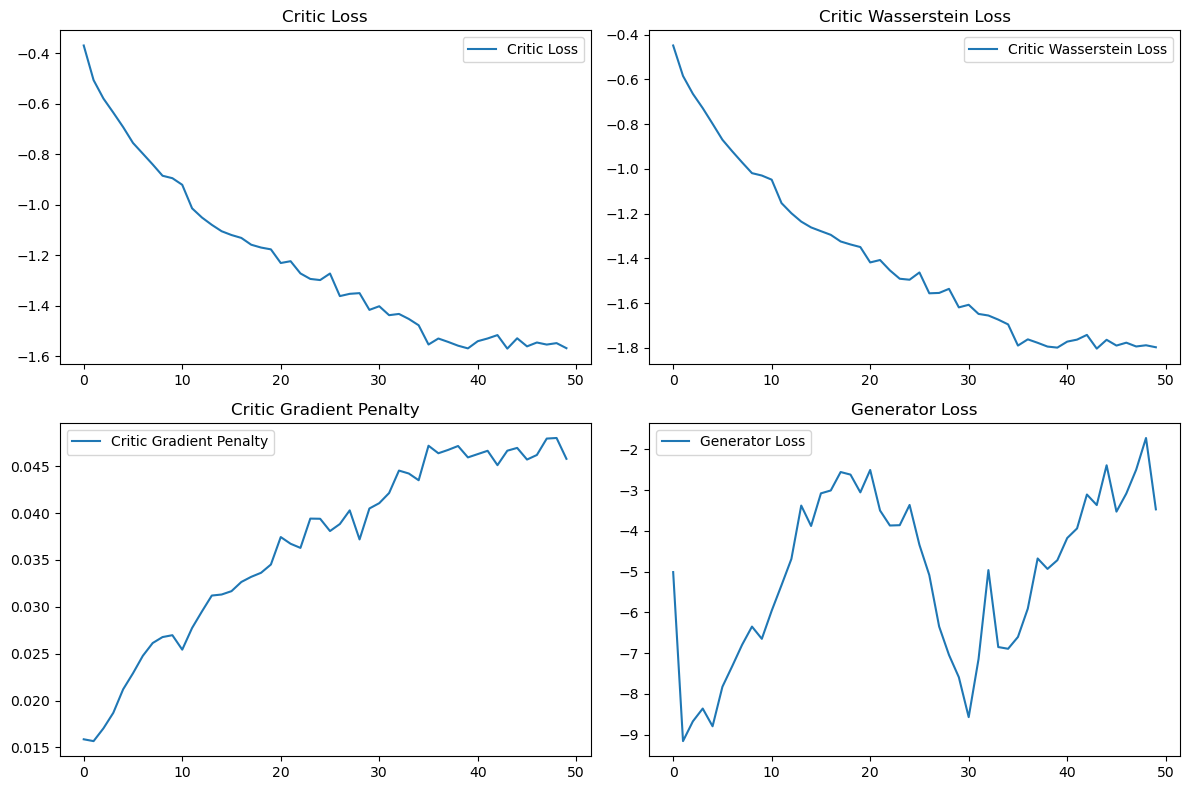

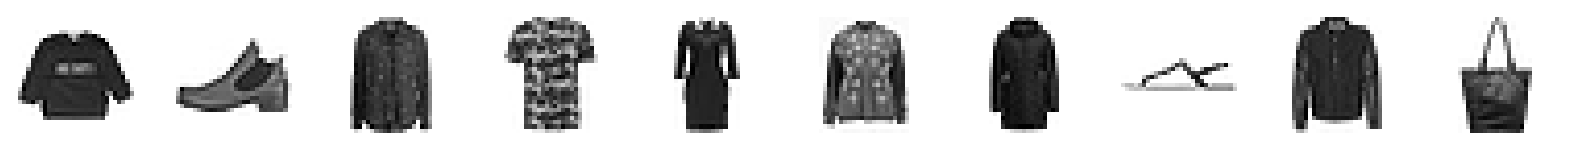

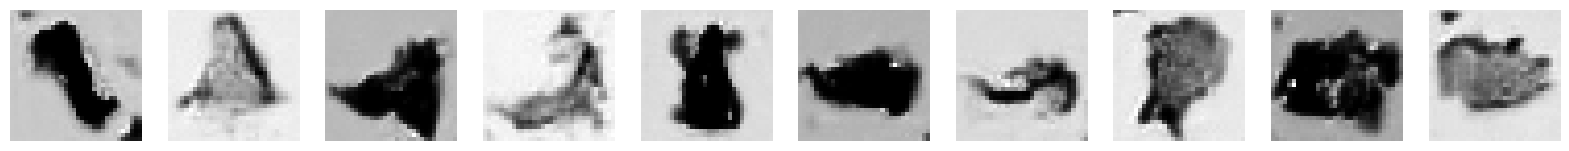

In [76]:
# model_dir = './my_saved_models'
# os.makedirs(model_dir, exist_ok=True)

# model_path = os.path.join(model_dir, 'wgangp_model')

# wgangp.save(model_path)

# custom_objects = {
#     'WGANGP': WGANGP,
#     # Include any other custom layers or functions used in your model
# }

# # Use the custom_object_scope when loading the model
# with custom_object_scope(custom_objects):
#     model = load_model(model_path)
    
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(training_metrics['c_loss'], label='Critic Loss')
plt.title('Critic Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(training_metrics['c_wass_loss'], label='Critic Wasserstein Loss')
plt.title('Critic Wasserstein Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(training_metrics['c_gp'], label='Critic Gradient Penalty')
plt.title('Critic Gradient Penalty')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(training_metrics['g_loss'], label='Generator Loss')
plt.title('Generator Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Displaying Reconstructions
num_images_to_display = 10
random_latent_vectors = tf.random.normal(shape=(num_images_to_display, latent_dim))
generated_images = wgangp.generator(random_latent_vectors)
display(x_train)
display(generated_images.numpy())

Loss Graphs:

- The Critic Loss and Critic Wasserstein Loss are trending downwards, which indicates that the critic (discriminator) is learning.
- The Critic Gradient Penalty is increasing. This suggests that the critic's gradients are becoming more penalized over time, which is a sign that the training process is enforcing the Lipschitz constraint.
- The Generator Loss is fluctuating, which is not unusual for GANs, but ideally, you would like to see this stabilize or decrease over time.

Generated Images:

- The top row of generated images looks like valid fashion items, which is a good sign. The fact that they resemble the actual items from the training dataset (bottom row of the first set of images) indicates that the generator has learned something meaningful.
- The bottom row of generated images, presumably from later in the training, seems to be losing structure and becoming less distinct. This may be due to the generator starting to lose the "game" against the critic.

Expected Results:

- Early in training, it's normal for generated images to be blurry or somewhat shapeless, and over time, they should become sharper and more recognizable.
- For WGANs, especially early on, the quality of images might fluctuate. As long as the trend over a larger number of epochs shows improvement, the training is likely progressing well.
- The fluctuations in the generator loss and the increasing gradient penalty might indicate that the generator is having a harder time keeping up with the critic. This could be due to many factors, including learning rates, model architecture, and the balance of power between the generator and critic.

Performance Improvement Tips:

- Longer Training: More epochs might be necessary to see clearer images.
- Hyperparameter Tuning: Adjust learning rates, batch sizes, and the gradient penalty coefficient.

Model Architecture: 

- Experiment with deeper or more complex architectures.
- Regularization: Ensure the generator and critic are not overfitting.
- Monitoring: Watch for signs of mode collapse or failure to converge and adjust training dynamically.